# Lab 2 - Training a Data Driven Model for Stellar Label Classification

# Abstract
Ever-increasing sizes of stellar spectroscopy surveys put a strain on conventional label-predicting pipelines, and more data-driven approaches are necessary. In this lab, we develop a data-driven generative model for stellar label prediction. Chosen, low-noise spectra from the APOGEE survey are combined with trusted labels from the ASPCAP pipeline, to serve as a training and testing set. Using this data, we initially develop a model to predict stellar spectrum from five labels, Teff, Log(g), Fe/H, Mg/Fe, and Si/Fe. This model is then reversed to a label-from-spectrum predicting model, using maximum likelihood methods. As an alternative to this approach, we train a label-from-spectrum predicting neural network, trained and tested on the same datasets. We find that the first predictive model has good predictive capabilities, with values deviating from ASPCAP by RMSE 74.32, 0.1543, 0.0537, 0.0516, 0.0558, for Teff, Log(g), Fe/H, Mg/Fe, and Si/Fe, respectively. The simplistic neural network fall slightly behind, with values ~30% higher. This gap is almost entirely closed in a second neural network implementation, using data augmentation and more epochs.

# 1. Introduction
## 1.1 APOGEE
The APOGEE survey contains vast amounts of high resolution (R~22'500) spectroscopy data from 146'000 stars in the Milky Way. The survey is done in a short infrared (1.51-1.70 µm) band, giving ~8000 wavelength pixels over three almost-overlapping bands.

## 1.2 Label Prediction - ASPCAP and data-driven approaches
The APOGEE data comes with labels derived using the [ASPCAP pipeline](http://adsabs.harvard.edu/abs/2015arXiv151007635G), which uses known physical properties of the stars (with some substantial approximations) to derive their labels from the spectrums. This approach is extremely time-consuming, and alternate, more data-driven approaches, like the Cannon (presented in [Ness et al.](https://arxiv.org/abs/1501.07604)) have been suggested. Such models hold certain advantages. They, first of all, tend to be much cheaper than physics-driven models. While training the model can be expensive, new predictions are usually very cheap. With large and good enough training sets, they could also learn features that might be lost in the approximations of a physical model.

We will in this lab create such a data driven model. The underlying idea is simply that there should be a deterministic relationship between some complete set of stellar labels, and the stellar spectrum. This relationship should be learnable through pure data-comparison between accurate labels and spectrum. The cannon employs three such labels, Teff, Log(g), and Fe/G, and we will employ two additional labels, Mg/Fe, and Si/Fe. The set of labels will in practice never be fully exhaustive, but the addition of more labels could increase our models' completeness.

# 2. Data Gathering
## 2.1 APOGEE Data Fetch

APOGEE provides their spectrum data in a series of ".fits" files, accessible through an archive on their webpage. The files are sorted in directories after their location ID and named after their object ID. Since we're only looking at 4 location IDs, we do a separate request of all files in these 4 directories using wget. The request is done using the following wget commands, to ensure only the desired files are requested, and that nothing else funky happens:

* -q --quiet (prevents wget prints.)
* -r --recursive (makes wget search through all hyperlinks in the provided directory, which contains our desired files.)
* -np --no-parent (prevents wget from recursively searching parent directories, so we don't download the entire internet.)
* -nd --no-directories (prevents wget from downloading directories.)
* -e robots=off (executes the command "robots=off", which ensures wget doesn't search the robot.txt anti-parse file included in the webpage.)
* -P --directory-prefix (where we want to save our files.)
* -A --accept (only include files following this pattern.)
* -R --reject (exclude files following this pattern. There is a bunch of similar-looking files in the directory. Don't know what they are, but we don't want them.)

while these "apStar" files contain the APOGEE spectrum data, the ASPCAP derived labels are all held in one "allStar" file. We also include this in our fetch.

Below we execute this pulling down ~2700 files, for a combined of ~8GB.

If you already have local access to these files, please create a directory ```stars/``` in the same folder as this notebook is run. In this, put the allStar file, as well as 4 directories by the name of the 4 location IDs (```stars/4230/```, ```stars/4262/```, ...), which should each contain their respective apStar files.

In [0]:
# ! mkdir -p stars/4230/
# ! mkdir -p stars/4262/
# ! mkdir -p stars/5162/
# ! mkdir -p stars/4241/

# ! wget -r -q -np -nd -e robots=off -P stars/4230/ -A 'apStar-r8-*.fits' -R 'apStar-r8-*-*.fits' https://data.sdss.org/sas/dr14/apogee/spectro/redux/r8/stars/apo25m/4230/
# ! wget -r -q -np -nd -e robots=off -P stars/4262/ -A 'apStar-r8-*.fits' -R 'apStar-r8-*-*.fits' https://data.sdss.org/sas/dr14/apogee/spectro/redux/r8/stars/apo25m/4262/
# ! wget -r -q -np -nd -e robots=off -P stars/5162/ -A 'apStar-r8-*.fits' -R 'apStar-r8-*-*.fits' https://data.sdss.org/sas/dr14/apogee/spectro/redux/r8/stars/apo25m/5162/
# ! wget -r -q -np -nd -e robots=off -P stars/4241/ -A 'apStar-r8-*.fits' -R 'apStar-r8-*-*.fits' https://data.sdss.org/sas/dr14/apogee/spectro/redux/r8/stars/apo25m/4241/
# ! wget -q -P stars/ https://data.sdss.org/sas/dr14/apogee/spectro/redux/r8/stars/l31c/l31c.2/allStar-l31c.2.fits

In [2]:
# Google Colab prerequisits
# ! pip install corner
# ! pip install emcee
# from google.colab import files
# uploaded = files.upload()
# from google.colab import drive
# drive.mount('/content/gdrive')
# ! cp -r '/content/gdrive/My Drive/Colab Notebooks/stars' '.'

## 2.2 Practical Considerations
We're gonna be storing all data in numpy arrays. ID data gets their own arrays, while labels are stored together in a 2D array. Flux and flux error data are stored in a 2-dimensional array. All data is matched by index on the first axis, corresponding to respective stars.

Below, we parse through at all the filenames we fetched with wget to extract object IDs and location IDs from these filenames to our arrays. We then parse through all the files and extract their flux and flux error data, as well as an error bitmask for later use.

## 2.3 Combining the spectra
Now, there are several flux (and error) spectra for each star in the .fits files, corresponding to different visits. Each visit is simply a spectrum observation done over some continuous exposure time. Multiple visits are usually performed for each star, at different times. These visits will need to be Doppler shifted to some reference velocity, since they might have been done at different points in the Earth's orbit, and therefore have different relative velocities, causing different red/blue-shifts.

Luckily for us, the spectrum data for each visit has both been Doppler shifted, and neatly combined into two combined spectra. The visits are combined into two combined spectra, using different weighting. The first is pixel-based, and the second uses a more combined, global weighing. We will be using the latter.

In [0]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import corner
import scipy.interpolate
import astropy
import seaborn as sns
# import mpld3
#mpld3.enable_notebook()
from tqdm import tqdm
from astropy.io import fits
from os import listdir
from os.path import isfile, join
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('seaborn-darkgrid')
mpl.rcParams['figure.figsize'] = [10.0, 4.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['font.size'] = 9
mpl.rcParams['legend.fontsize'] = 'Large'
mpl.rcParams['figure.titlesize'] = 'Small'

np.random.seed(1942)

In [4]:
obj_ids = []
loc_ids = []
target_ids = []
for loc in ['4230', '4262', '5162', '4241']:
    filenames = listdir('stars/' + loc)
    for name in filenames:
        if isfile('stars/' + loc + '/' + name):
            name = name.split('r8-')[1]
            name = name.split('.fits')[0]
            obj_ids.append(name)
            loc_ids.append(loc)
            target_ids.append(loc + '.' + name)

nr_stars = len(obj_ids); print(f"Fetched data for {nr_stars} stars.")

Fetched data for 2723 stars.


In [5]:
nr_pixels = 8575  # 8575 seems to be the number of flux-pixels in each dataset.
spec = np.zeros((nr_stars, nr_pixels), dtype=np.float32)  # APOGEE gives data in float32
spec_error = np.zeros((nr_stars, nr_pixels), dtype=np.float32)
bitmask = np.zeros((nr_stars, nr_pixels), dtype=int)

for i in tqdm(range(nr_stars)):
    filename = 'stars/' + loc_ids[i] + '/apStar-r8-' + obj_ids[i] + '.fits'
    with fits.open(filename) as infile:
        spec[i] = (infile[1].data)[1]
        spec_error[i] = (infile[2].data)[1]
        bitmask[i] = (infile[3].data)[1]

with fits.open(filename) as infile:
    CRVAL1 = infile[0].header['CRVAL1']
    CDELT1 = infile[0].header['CDELT1']
wl = np.logspace(CRVAL1, CRVAL1 + (nr_pixels-1)*CDELT1, nr_pixels)

100%|██████████| 2723/2723 [00:38<00:00, 70.00it/s]


## 2.4 First Look
We now have data for spectrum and error data, as well as object and location IDs, all matched by index.

```spec``` and ```spec_error``` is (2723)x(8575) arrays, as there are initially 2723 stars, each with flux observations at 8575 different wavelengths. Below we have plotted the spectrum and error spectrum of 3 chosen stars. The entire spectrums are plotted to the left, and a zoomed in, more readable version is on the right. Since the errors are very small, and the data very noisy, plotting error bars on the data is inconvenient.

A few things are immediately apparent. There are pixels with no flux-data in all 3 spectrums. These are the regions outside, or in between, the 3 bands in the APOGEE survey. The wavelengths are still included, but the flux is set to 0, and they are marked with errors of 1e10 (Or, most of them are. We explore this below). On the more readable spectrums on the right, we see that the errors tend to have a convex form, with most lying on a rather well-defined curve, with some outliers. The data also has some overall trends, decaying or increasing towards higher wavelengths. If we consider stars perfect blackbodies, the curves should obey Planck's law, and the general trend is a result of being on the left or right of the peak in the blackbody radiation spectrum. Errors and instrumental considerations also come into play. We will explore these general trends later when we attempt to normalize the flux across all stars.

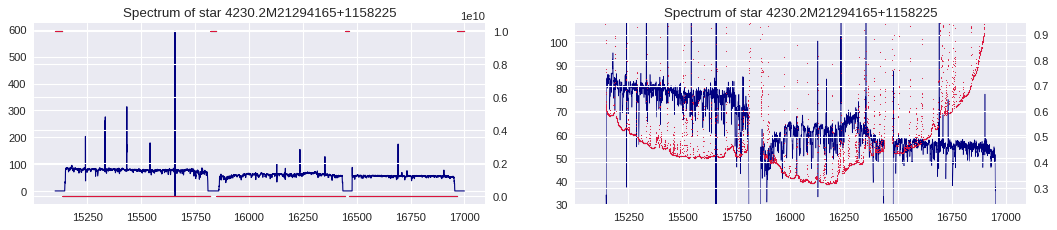

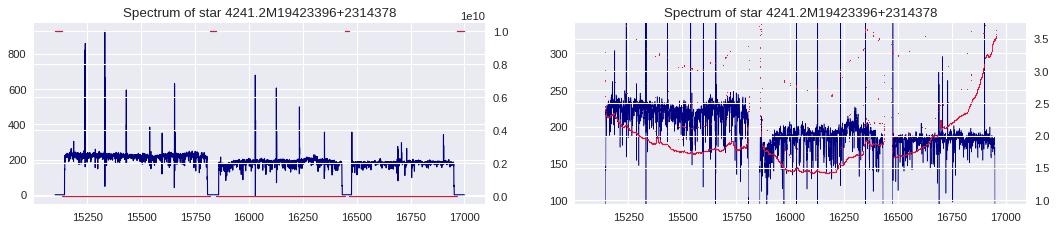

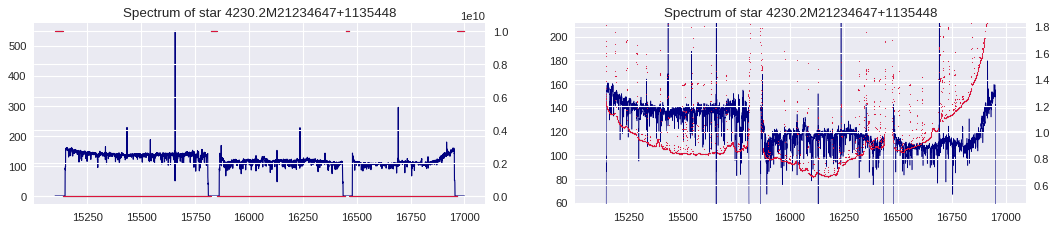

In [6]:
for i in range(3):
    j = np.random.randint(0, nr_stars)
    spectrum_1 = spec[j]
    spec_error_1 = spec_error[j]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,3))
    ax1.plot(wl, spectrum_1, lw=1, c="navy")
    ax1.set_title(f"Spectrum of star {target_ids[j]}")
    ax11 = ax1.twinx()
    ax11.scatter(wl, spec_error_1, s=0.4, c="crimson");

    ax2.plot(wl, spectrum_1, lw=0.5, c="navy")
    ax2.set_title(f"Spectrum of star {target_ids[j]}")
    ax2.set_ylim(0.5*np.median(spectrum_1), 1.8*np.median(spectrum_1))
    ax22 = ax2.twinx()
    ax22.scatter(wl, spec_error_1, s=0.4, c="crimson");
    ax22.set_ylim(0.5*np.median(spec_error_1), 2*np.median(spec_error_1))

## 2.5 Finding consistent band sizes
We don't really care for the areas outside the bands and establishing where the bands end is important. This becomes especially important when we observe that the bands end at different wavelengths for different spectra. This is probably because our data has been doppler shifted to a common velocity frame for all visits over all spectra. This results in a shift in the spectrum, in different directions for each visit, which leads to the bands not always corresponding.

Although APOGEE has tagged most out-of-band areas with high error, it tends to stop before the band actually begins. To deal with this mess, we will employ two corrections to the data:
* We will set the error of all very low flux areas to an extremely high value, expanding on what APOGEE has done. We have set this cutoff limit to all fluxes below 5% of the median flux.
* We will define a conservative limit on where the bands actually lie and ignore all values falling outside this range for in all our models. For this range, we will employ the same range used in APOGEEs pseudo-continuum normalization, which consists of 7214 of the 8575 original pixels.

The latter correction will mean cutting off some actually good data in some spectrums, but there is still plenty to work with, and this improves consistency throughout our spectrums. Some hindsight reveals that cutting slightly into each band improves the final model.

In [0]:
spec_error[spec < 0.05*np.median(spec, axis=0)] = 1e10

band_idxs = np.array([[322, 3241], [3648, 6047], [6412, 8305]])
band_cut = np.zeros(nr_pixels, dtype=bool)
band_cut[band_idxs[0,0]:band_idxs[0,1]+1] = True
band_cut[band_idxs[1,0]:band_idxs[1,1]+1] = True
band_cut[band_idxs[2,0]:band_idxs[2,1]+1] = True

band_idxs_reduced = np.array([[0, 2919], [2920, 5319], [5320, 7213]])

## 2.6 Label Extraction
The AllStars file provided by APOGEE contains labels derived by ASPCAP. The labels of interest are:
* Teff: Effective Temperature.
* Log(g): Natural logarithm of surface gravity.
* Fe/H: Iron to Hydrogen ratio.
* Mg/Fe: Magnesium to Iron ratio.
* Si/Fe: Silisium to Iron ratio.

The labels are stored by location and object IDs, which we have, so we simply parse the file and extract the following labels for each star. In addition, the file contains the SNR(Signal to Noise Ratio) information for each star.

Some stars show up more than once (identical target_ids) in the ASPCAP file. This might be due to multiple observations, that for some reason aren't counted as multiple visits. Either way, for simplicity we will choose whatever file shows the lower SNR, as that is a naive indication of better data.

In [8]:
label_names = ["Teff", "Log(g)", "Fe/H", "Mg/Fe", "Si/Fe"]
label_xlims = [[3200, 5700],[-0.5, 4.5], [-1.2, 0.8], [-0.4, 0.6], [-0.4, 0.5]]
labels = np.zeros((nr_stars, 5), dtype=np.float32)
label_errors = np.zeros((nr_stars, 5), dtype=np.float32)
SNR_data = np.zeros(nr_stars, dtype=np.float32)

with fits.open('stars/allStar-l31c.2.fits') as label_file:
    label_data = label_file[1].data
    duplicates = 0
    for i in tqdm(range(nr_stars)):
        target_id = loc_ids[i] + '.' + obj_ids[i]
        matches =  np.argwhere(label_data['TARGET_ID'] == target_ids[i])
        if len(matches) > 1: # Some har multiple TARGET_IDs. Just pick the one with highest SNR.
            duplicates += 1
            idx = matches[np.argmax(label_data['SNR'][matches])]
        else:
            idx = matches[0]
        labels[i,0] = label_data['Teff'][idx]
        labels[i,1] = label_data['logg'][idx]
        labels[i,2] = label_data['FE_H'][idx]
        labels[i,3] = label_data['MG_FE'][idx]
        labels[i,4] = label_data['SI_FE'][idx]
        label_errors[i,0] = label_data['Teff_ERR'][idx]
        label_errors[i,1] = label_data['logg_ERR'][idx]
        label_errors[i,2] = label_data['FE_H_ERR'][idx]
        label_errors[i,3] = label_data['MG_FE_ERR'][idx]
        label_errors[i,4] = label_data['SI_FE_ERR'][idx]
        SNR_data[i] = label_data['SNR'][idx]

print(f"There were {duplicates} duplicates out of {nr_stars} stars.")

100%|██████████| 2723/2723 [00:55<00:00, 48.68it/s]

There were 292 duplicates out of 2723 stars.


# 3. Data Cleaning and Manipulation
## 3.1 Quality Cuts
Quite a few of the stars do not have ASPCAP derived labels, due to data quality issues. ASPCAP signals this by setting the label value to -9999. We have no use for these stars, and they will be removed. We will also remove stars with a signal to noise ratios of below 50, as well as very low metallicity stars (Fe/H < -1). A few stars have 0 flux all over the spectrum. These are also obviously useless and will be removed.

In [9]:
quality_cut_idx = (labels[:,0] != -9999.) & (labels[:,1] != -9999.) & (labels[:,2] != -9999.) \
                & (labels[:,3] != -9999.) & (labels[:,4] != -9999.) \
                & (SNR_data > 50) & (labels[:,2] > -1) & (spec != 0.).any(axis=1)


spec = spec[quality_cut_idx]
spec_error = spec_error[quality_cut_idx]
labels = labels[quality_cut_idx]
SNR_data = SNR_data[quality_cut_idx]
bitmask = bitmask[quality_cut_idx]
label_errors = label_errors[quality_cut_idx]

nr_stars = len(bitmask)
print(f"Cut reduced number of objects to {nr_stars}")

Cut reduced number of objects to 1692


### 3.1.1 A quick look at the label space

Below we have done a corner plot of the label space. The labels seem to have low covariance, with the exception of effective temperature and surface gravity, which have a very strong, seemingly linear trend. The atmospheric labels (Fe/H, Mg/Fe, and Si/Fe) also all seem to have some weaker correlation. Low covariance between the labels is a good thing for our model, as it means more linearly independent information can be constructed from them. If one label is simply a function of another(or several), it is not actually a new piece of information that can be used to predict stellar spectra.

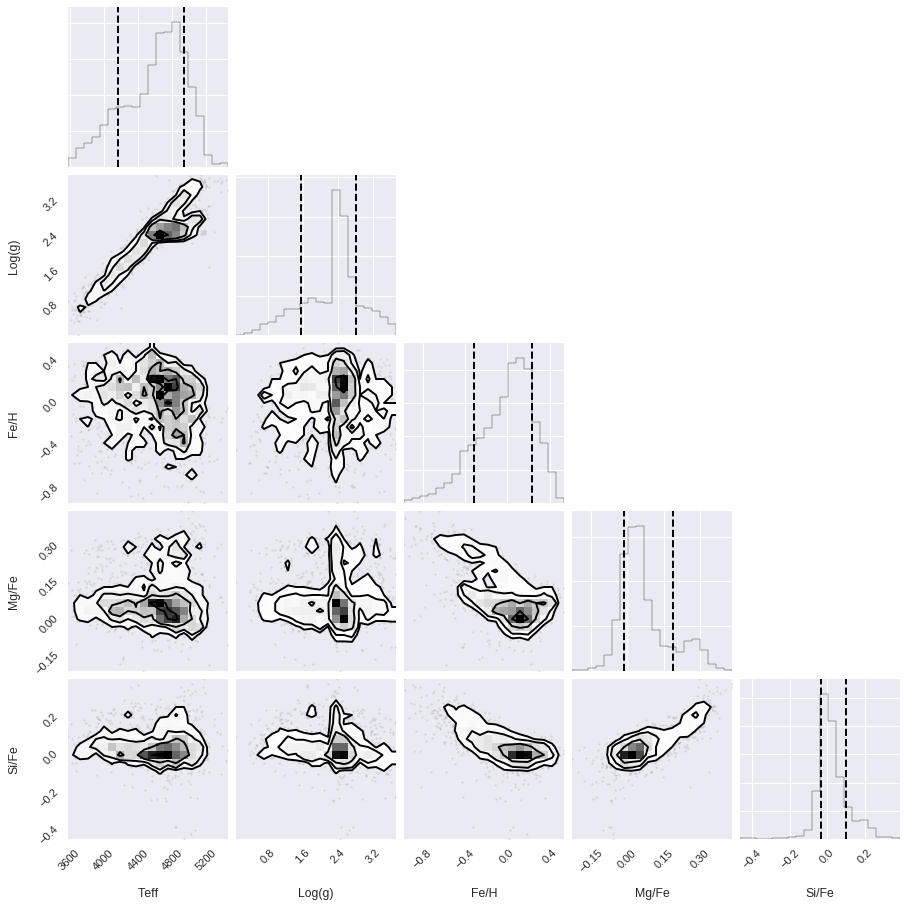

In [10]:
fig = corner.corner(labels, labels=label_names, quantiles=[0.16, 0.84]);

## 3.2 Pseudo-Continuum Normalization
### 3.1.1 Basic idea
To be able to compare flux measurements for different stars, we need some sort of relative flux scale that holds for every star. We are simply interested in the relative absorption line strength - how large fraction of the star's flux is reduced by the absorption line at every wavelength. This requires us to know what the stars flux/wavelength relation looked like without absorption. One option is to derive a theoretical line, from first principles. This would require large assumptions on several important aspects of the star, combined with the fact that we would have to blindly trust that our labels are accurate (and sufficient to form such a model).

An alternative, more data-driven approach is suggested in [Ness et al.](https://arxiv.org/abs/1501.07604), section 2.3. The approach involves picking out pixels known to be less affected by absorption lines. These pixels should represent a fairly good continuum of the spectrum. This paper extracts these points by running The Cannon iteratively, first with a more naive pseudo-continuum, to pick out points weakly affected by absorption.

We will employ our own pseudo-continuum normalization, using the less affected pixels provided by The Cannon. They are loaded from the "pixels_cannon.npy" file. Using this, we will, as suggested in Ness et al., fit a second order polynomial to each of the three wavelength bands. Exhaustive testing of higher order polynomials revealed that second order across all three bands provides the best result. The polynomials will also be weighted by the squared inverse of their error. A "wavelength.npy" file, containing the wavelengths of the pixels (as they do not sync entirely up with ours) is also loaded. Before we fit the second order polynomial to the chosen pixels, we will also attempt to remove large outliers, by running through the pixels in bulks of 20, and removing anything that falls very far from the median of those 20 pixels.

The Cannon arrays contain only 7214 pixels, against the total 8575 pixels provided in the APOGEE datasets. This is the reduced set of pixels that we consider to actually lie on the bands, and we will employ only these in our models. Everything containing only these 7214 pixels will be referred to as "reduced" in the code.

In [0]:
spec_reduced = spec.copy()[:,band_cut]
spec_error_reduced = spec_error.copy()[:,band_cut]

In [0]:
wl_reduced = np.load("wavelength.npy")  # Wavelength array of reduced pixels.
nr_pixels_reduced = len(wl_reduced)

clean_cut_reduced = np.load("pixels_cannon.npy")  # Boolean cut array for "clean" pixels at reduced wavelengths.
nr_clean_pixels = np.sum(clean_cut_reduced)
wl_clean = wl_reduced[clean_cut_reduced]  # Wavelength aray for "clean" pixels.
nr_clean_pixels

clean_cut = np.zeros(nr_pixels, dtype=bool)  # Boolean cut array for "clean" pixels at full 8575 pixel spectrum.
for i in range(3):
    clean_cut[band_idxs[i,0]:band_idxs[i,1]] = clean_cut_reduced[band_idxs_reduced[i,0]:band_idxs_reduced[i,1]]

### 3.1.2 Setting up and testing the pseudo-continuum normalization
Below, the outlier and polyfit functions are defined, as explained below. We have chosen a 10% distance from the median tolerance limit on the outlier algorithm for each batch-size of 20. The result of this outlier removal is plotted below, where removed outliers are marked in red. As we can see, the algorithm is relatively effective. It could always be further improved, but the impact is probably not too substantial.

In [0]:
def find_outliers(data):
    # Iterates through 1D "data" object in bulks of 20 points, tagging datapoints lying outside 10% of median.
    # Returns boolean array with False tag on outliers.
    not_outliers = np.ones(len(data), dtype=bool)
    group_points = 20
    iterations = int(len(data)/group_points)
    for i in range(iterations-1):
        subdata = data.copy()[i*group_points:(i+1)*group_points]
        not_outliers[i*group_points:(i+1)*group_points] = np.abs(subdata - np.median(subdata))/np.median(subdata) < 0.1
    subdata = data.copy()[(iterations-1)*group_points:]
    not_outliers[(iterations-1)*group_points:] = np.abs(subdata - np.median(subdata))/np.median(subdata) < 0.1
    return not_outliers


poly_band_indexes = [[0, 3450],[3450, 6200], [6200, 8750]]  # Intervals to perform polyfit on.

def get_band_polyfit(wl, spec, spec_err, clean_cut=clean_cut, degrees=(2,2,2)):
    # Calculates the polynomial fit of chosen "clean_cut" pixels of spec(wl) in three bands,
    # with chosen degrees, considering errors.
    polyfit = np.zeros(nr_pixels)
    for b in range(3):  # One polyfit per band.
        degree = degrees[b]
        # Keeping only current band.
        band_wl = wl[poly_band_indexes[b][0] : poly_band_indexes[b][1]]
        band_spec = spec[poly_band_indexes[b][0] : poly_band_indexes[b][1]]
        band_err = spec_err[poly_band_indexes[b][0] : poly_band_indexes[b][1]]

        # Keeping only clean pixels.
        band_wl_clean = band_wl[clean_cut[poly_band_indexes[b][0] : poly_band_indexes[b][1]]]
        band_spec_clean = band_spec[clean_cut[poly_band_indexes[b][0] : poly_band_indexes[b][1]]]
        band_err_clean = band_err[clean_cut[poly_band_indexes[b][0] : poly_band_indexes[b][1]]]

        # Keeping only non-outliers.
        outlier_cut = find_outliers(band_spec_clean)
        band_wl_clean2 = band_wl_clean[outlier_cut]
        band_spec_clean2 = band_spec_clean[outlier_cut]
        band_err_clean2 = band_err_clean[outlier_cut]
        
        p = np.polyfit(band_wl_clean2, band_spec_clean2, deg=degree, w=1/band_err_clean2)
        poly = np.zeros(len(band_wl))
        for i in range(degree+1):
            poly += p[-i-1]*band_wl**i
        polyfit[poly_band_indexes[b][0] : poly_band_indexes[b][1]] = poly
    return polyfit


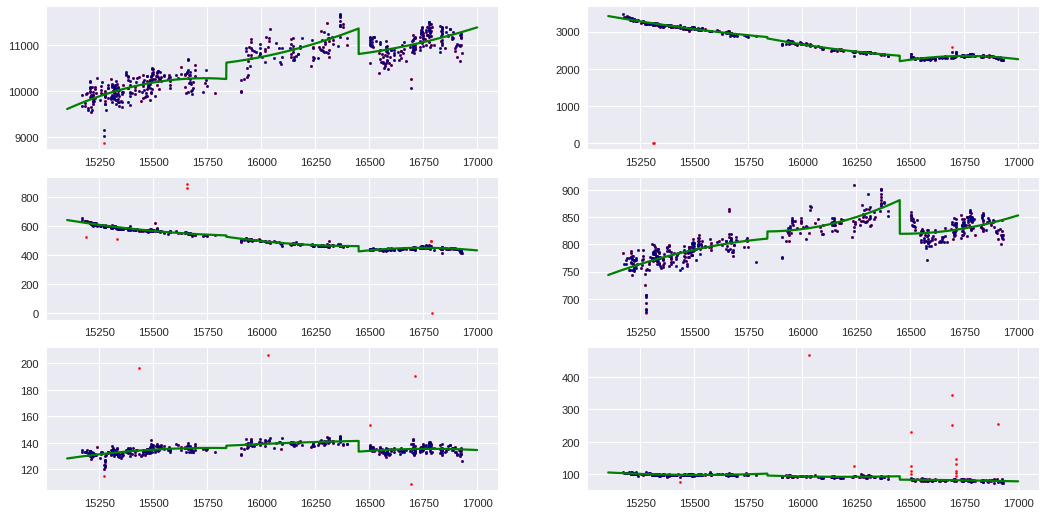

In [14]:
fig, ax = plt.subplots(3, 2, figsize=(16,8))
for i, j in enumerate(np.random.randint(0, nr_stars, 6)):
    polyfit = get_band_polyfit(wl, spec[j], spec_error[j], degrees=(2,2,2))
    non_outlier_cut = find_outliers(spec[j][clean_cut])
    ax[i//2, i%2].scatter(wl_clean, spec[j][clean_cut], s=4, c="red")
    ax[i//2, i%2].scatter(wl_clean[non_outlier_cut], spec[j][clean_cut][non_outlier_cut], s=4, c="navy")
    ax[i//2, i%2].plot(wl, polyfit, c="g", lw=2)

### 3.3.3 Normalize them all!
Below we have employed our pseudo-continuum normalization on all stars. The effect is plotted for a handful of randomly chosen stars. On the left-hand side, we see the original spectrum, overplotted with the fitted polynomial. In the middle, we see the pixels used in the fit, and on the right, we see the final resulting normalized spectrum. The normalized spectrum all in all look very good, while there are some features that can be worrisome. Especially towards the edged of the bands, the spectrum tends to diverge a bit. The normalization algorithm could definitively be improved for better edge-handling.

100%|██████████| 1692/1692 [00:09<00:00, 179.68it/s]


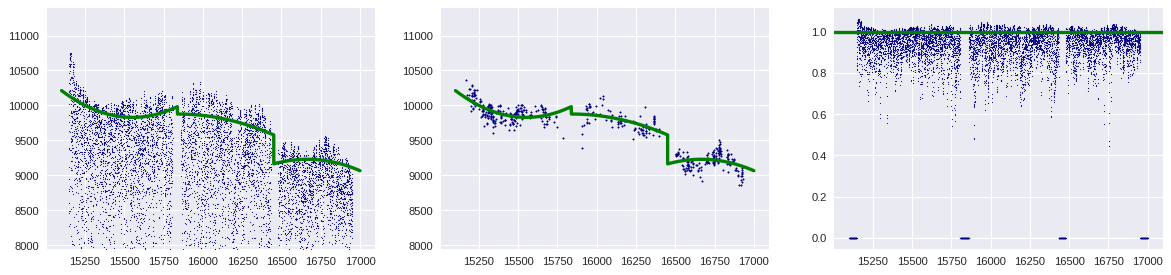

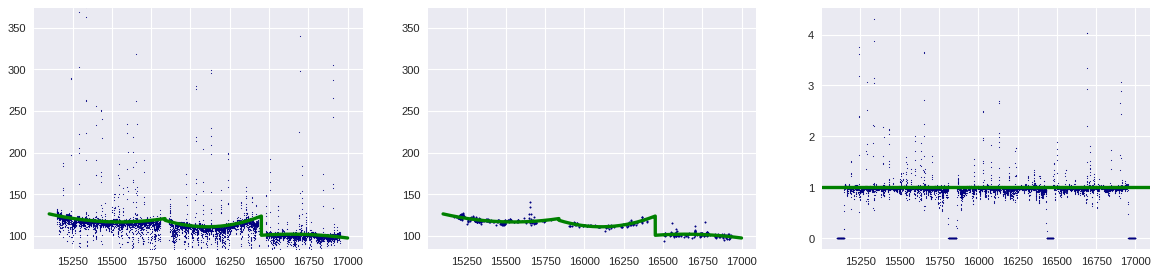

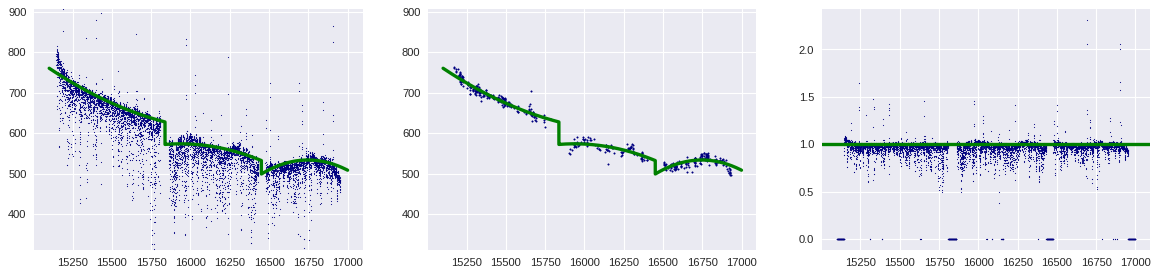

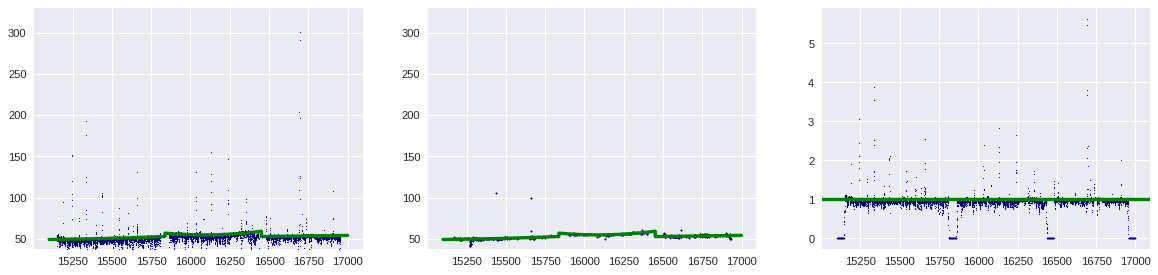

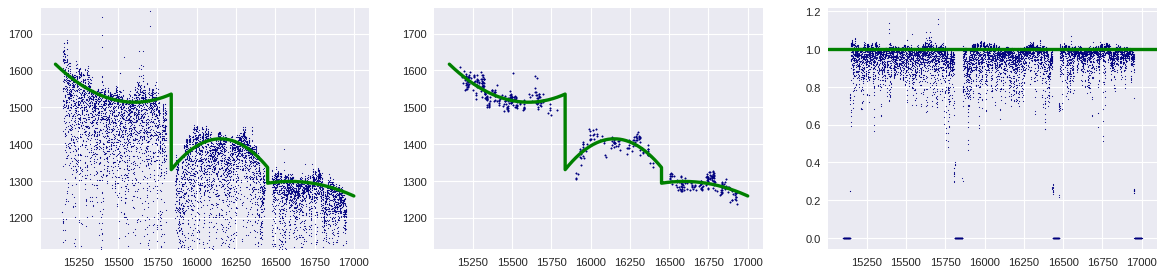

In [15]:
polynomial_fits = np.zeros((nr_stars, nr_pixels))
for j in tqdm(range(nr_stars)):
    polyfit = get_band_polyfit(wl, spec[j], spec_error[j], degrees=(2,2,2))
    if np.sum(np.isnan(polyfit)) > 0:
        print(np.sum(np.isnan(polyfit)))
    if np.sum(np.isinf(polyfit)) > 0:
        print(np.sum(np.isinf(polyfit)))

    polynomial_fits[j] = polyfit
    if j %387 == 0:
        fix, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,4))
        ymax, ymin = np.max(spec[j][clean_cut])*1.1, np.min(spec[j][clean_cut])*0.9
        ax1.scatter(wl, spec[j], s=0.5, color="navy")
        ax1.plot(wl, polyfit, c="g", lw=3)
        ax2.plot(wl, polyfit, c="g", lw=3)
        ax2.scatter(wl_clean[non_outlier_cut], spec[j][clean_cut][non_outlier_cut], s=2, c="navy")
        ax1.set_ylim(ymin, ymax); ax2.set_ylim(ymin, ymax);
        ax3.scatter(wl, spec[j]/polyfit, s=0.5, c="navy")
        ax3.axhline(y=1, c="g", lw=3)

Applying the normalization to all data:

In [0]:
spec_norm = spec.copy()/polynomial_fits
spec_error_norm = spec_error.copy()/polynomial_fits
spec_error_norm[spec_error_norm > 1e4] = 1e10  # Putting flagged high-error objects back to 1e10, for convenience.


# 3.3 Applying bitmasks on bad data
APOGEE provides a "possible error" bitmask for each pixel of each star. The meaning of each bit is explained [here](https://www.sdss.org/dr14/algorithms/bitmasks/#APOGEE_PIXMASK), but they all indicate that something might be wrong with the pixel. The idea is to set the standard error of all pixels we suspect might be affected by some error-inducing problem to a very large value, just like we did with the zero-flux pixels.

Below we have plotted the distribution of different bitmask flags. As we can see, only 7 flags are actually active in our data, and 4 of these account for most cases. The plot does not account for overlap (one pixel may have more than one flag), but we found that very few pixels have more than one flag. The 0-flag seems to correspond to pixels marked with 0 flux, which we have already marked, so it will not contribute anything.

Now, some flags are less serious than others, and there is an argument for treating them differently. Some experimenting does, however, show that simply filtering out pixels with any of the flags yields the best final predictive capabilities for our model. We seem to have enough data to go on that it is beneficial to be more critical of potential errors. If we had substantially less data, there might have been a better payoff for discarding fewer suspicious pixels.

We will simply assume that any pixel with non-zero mask value (which means no flag is set) is bad, and their standard errors will be set accordingly. As seen in the code-prints below, this only removes ~16.5% of our on-band pixels (i.e. not accounting for the pixels outside the bands, which we won't use).

Out of a total of 12206088 pixels, 2009042 has at least one error bitflag, corresponding to 16.46 %


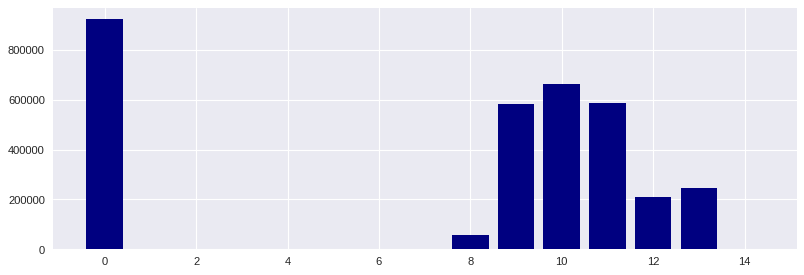

In [17]:
bitmask_unpacked = np.zeros((nr_stars, nr_pixels, 15), dtype=bool)

for i in range(15):
    bitmask_unpacked[:, :, i] = ((bitmask & 2**i) != 0)
    
bitmask_count = np.sum(bitmask_unpacked, axis=(0,1))
plt.figure(figsize=(12,4))
plt.bar(range(15), bitmask_count, color="navy")
print(f"Out of a total of {bitmask[:,band_cut].size} pixels, {np.sum(bitmask[:,band_cut] != 0)} has at least one error bitflag, corresponding to {100*np.sum(bitmask[:,band_cut] != 0)/bitmask[:,band_cut].size:.2f} %")

spec_error_norm[bitmask != 0] = 1e10  # Discarding bad pixels.

### 3.3.1 A final look at data errors.
We have just increased the error of a lot of pixels, and need to do a short analysis of what kind of data we are left with. The plots below of some random spectra and their errors makes it evident that some stars were hit much harder by the bitmask than others, and might not be worth keeping at all. Below this again, we have plotted a histogram of the number of pixels tagged as unusable for each star (not including the pixels tagged as unusable because they are out-of-band, but only on-band pixels). It reveals that many stars have a substantial amount of pixels tagged. These stars are of no use to our model, and we have decided to discard all stars with more than 3000 unusable pixels (corresponding to more than 41.5%).

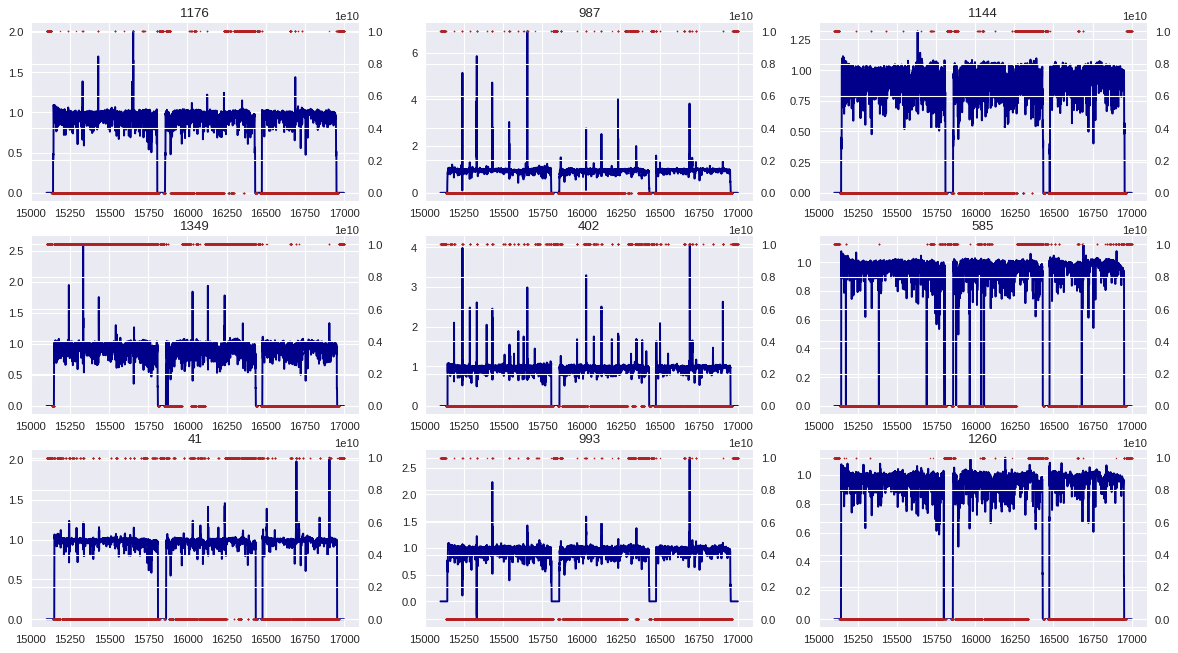

In [18]:
fig, ax = plt.subplots(3, 3, figsize=(18, 10))
plot_nrs = np.random.randint(0, nr_stars, 9)
for i in range(9):
    ax[i//3, i%3].set_title(f"{plot_nrs[i]}")
    ax[i//3, i%3].plot(wl, spec_norm[plot_nrs[i]], c="darkblue")
    ax2 = ax[i//3, i%3].twinx()
    ax2.scatter(wl, spec_error_norm[plot_nrs[i]], s=1, c="firebrick")

In [0]:
spec_norm_reduced = spec_norm[:,band_cut]
spec_error_norm_reduced = spec_error_norm[:,band_cut]

Removing 176 high-error stars, reducing number of usable stars from 1692 to 1516.


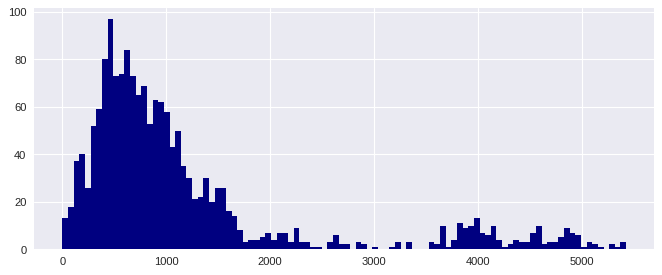

In [20]:
x = np.sum(spec_error_norm_reduced > 1e8, axis=1)
plt.hist(x, bins=100, color="navy")
spec_norm_reduced2 = spec_norm_reduced[np.sum(spec_error_norm_reduced > 1e8, axis=1)<3000]
spec_error_norm_reduced2 = spec_error_norm_reduced[np.sum(spec_error_norm_reduced > 1e8, axis=1)<3000]
labels2 = labels[np.sum(spec_error_norm_reduced > 1e8, axis=1)<3000]
nr_stars_final = spec_norm_reduced2.shape[0]
print(f"Removing {np.sum(x>3000)} high-error stars, reducing number of usable stars from {nr_stars} to {nr_stars_final}.")

In [0]:
good_pixels = spec_error_norm_reduced2 < 1e9  # Boolean error tagging pixels as usable or unusable (very high error).

# 4. The Spectrum Prediction Model
With all data-cleaning out of the way, we are finally ready to build our first predictive model.
## 4.1 Setting up the data
### 4.1.1 Dividing in two
Sklearn has a method for splitting a random selection of input data into two randomly selected groups. Below, we employ this to get a training set with 67% of the data, and a testing set with 33% of the data. This results in around a thousand stars for the training set, and five hundred for the testing set. Both should be respectable enough sizes to get a fair model.

In [22]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

labels_train, labels_test, spectrum_train, spectrum_test, error_train, error_test = train_test_split(labels2, spec_norm_reduced2, spec_error_norm_reduced2, test_size=0.33, random_state=42, shuffle=True)
good_pixels_train = error_train < 1e9
good_pixels_test = error_test < 1e9
nr_training_stars, nr_testing_stars = labels_train.shape[0], labels_test.shape[0]
print(f"Divided data into training set of {nr_training_stars} objects, and testing set of {nr_testing_stars} objects.")

Divided data into training set of 1015 objects, and testing set of 501 objects.


### 4.1.2 Rescaling Labels
Looking at the raw numbers of our labels in their respective units, it is clear they are of different magnitudes. Especially the effective temperature sticks out, being over a factor 1000 larger than the other values. We will simply scale all our labels to mean 0 and variance 1, using sklearn's "StandardTransformer" module, which performs the scaling:

\\[
    \theta' = \frac{\theta - \bar{\theta}}{\sigma_\theta}
\\]

Such scaling is useful both for numerical precision in calculations, the convergence rate of learning models, and a more meaningful comparison of values between labels. Below we have plotted the distributions of labels in the training set, before(above) and after(below) scaling.

In [0]:
# pt = preprocessing.PowerTransformer()
Scaler = preprocessing.StandardScaler()
labels_train_scaled = Scaler.fit_transform(labels_train)
labels_test_scaled = Scaler.transform(labels_test)

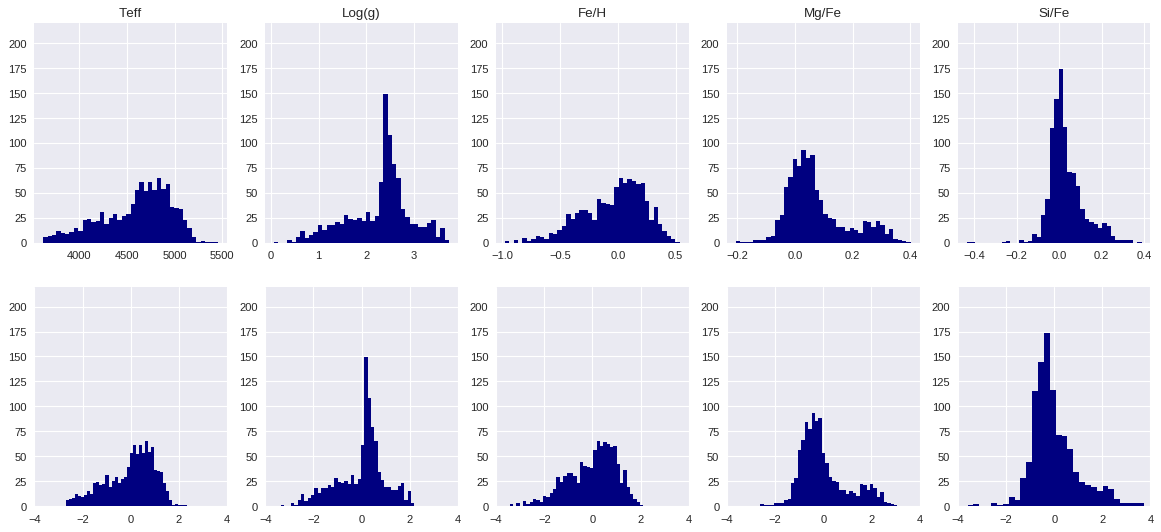

In [24]:
fig, ax = plt.subplots(2, 5, figsize=(18,8))
for i in range(5):
    ax[0,i].set_title(label_names[i]); ax[0,i].set_ylim(0, 220)
    ax[0,i].hist(labels_train[:,i], bins=40, color="navy")
    ax[1,i].hist(labels_train_scaled[:,i], bins=40, color="navy")
    ax[1,i].set_xlim(-4, 4); ax[1,i].set_ylim(0, 220)

## 4.2 Building the Model
We will now build a model for generating spectrum from a set of labels. Each star consist of a set of five labels $l_n = [Teff_n,...,SiFe_n]$. Consider each of the $N$ star to have a label-vector $\boldsymbol\ell_{n}$ with $K$ different labels. In our case, the label-vector will consist of our 5 labels, in addition to any function of them we would wish to create:

$\boldsymbol\ell_{n} = \left[Teff_n,\ logg_n,\ ...,\ f(Teff_n, logg_n...),\ ...\right]$.

For each wavelength $\lambda$, we will assume that the flux can be written as a linear combination of these labels, with a set of coefficients $\boldsymbol \theta_\lambda$ yet to be decided. For some star $n$, we would have

\\[
    f_{n\lambda} = \boldsymbol \ell_n \cdot \boldsymbol \theta_\lambda 
\\]

where $\boldsymbol \theta_\lambda$, for each wavelength, is a vector of coefficients which have to be solved for.

Solving for all $N$ stars at once leaves this as a matrix equation to be solved:
\\[
    \boldsymbol f_{\lambda} = \hat{\boldsymbol \ell} \cdot \boldsymbol \theta_\lambda 
\\]

Ness et al., constructs a likelihood for this model, employing an optimizer to solve for the coefficients. Optimizers are computationally rather expensive, and we will simply solve this as a linear algebra exercise.

Now, in principle, all that remains is to solve the equation above for the coefficients. We would, however, like to also make use of our standard error estimates, to weight the different pixels. This will increase the accuracy and predictive power of our coefficients. For weights, we will simply use the square inverted standard error. We introduce the diagonal weight matrix

\\[
    W = \begin{pmatrix} 1/\sigma_0^2 &0& 0 & \cdots \\
                        0 & 1/\sigma_1^2 & 0 & \cdots \\
                        \ddots & \ddots & \ddots & \ddots
        \end{pmatrix}
\\]

This expands the linear algebra problem we have to solve to

\\[
     \hat{\boldsymbol \ell}^T \boldsymbol W\, \boldsymbol f_{\lambda} =\hat{\boldsymbol \ell}^T \boldsymbol W\,  \hat{\boldsymbol \ell}\, \boldsymbol \theta_\lambda 
\\]
where everything but $\boldsymbol \theta_\lambda$ is still known, so it's still just a matrix equation.

Now for our choice label vectors, $\boldsymbol \ell_n$. We will, as suggested in Ness et al., use all quadratic combinations of our five stellar labels (the paper has three, but the principle is the same). Including a constant term, the labels vectors will consist of 21 elements:

\\[
    \boldsymbol \ell_n = [1,\ Teff_n,\ logg_n,\ FeH_n,\ MgFe_n,\ SiFe_n,\ Teff_n^2,\ ...\ ,\ SiFe_n^2,\ Teff_n\cdot logg_n,\ ...\ ,\ MgFe_n\cdot SiFe_n ]
\\]
for each star, $n$.

Combining them, we get a label matrix. This, as well as the least-square solving of all coefficients $\boldsymbol \theta_\lambda$ (also packed into a coefficient matrix), is done below.

In [0]:
label_means = np.mean(labels_train, axis=0)

label_matrix = np.zeros((nr_training_stars, 21))
label_matrix[:, 0] = 1
label_matrix[:, 1:6] = labels_train_scaled
label_matrix[:, 6:11] = labels_train_scaled**2
label_matrix[:, 11:15] = labels_train_scaled[:,0,None]*labels_train_scaled[:, 1:]
label_matrix[:, 15:18] = labels_train_scaled[:,1,None]*labels_train_scaled[:, 2:]
label_matrix[:, 18:20] = labels_train_scaled[:,2,None]*labels_train_scaled[:, 3:]
label_matrix[:, 20] = labels_train_scaled[:,3]*labels_train_scaled[:, 4]

In [26]:
coefficient_matrix = np.zeros((nr_pixels_reduced, 21)) # The 21 coefficients of each pixel.

for i in tqdm(range(nr_pixels_reduced)):
    weights_matrix = np.diag( 1/error_train[:,i]**2 )
    pixel_vector = spectrum_train[:,i]
    coeff, res, rank, s = np.linalg.lstsq(label_matrix.T@weights_matrix@label_matrix, np.dot(label_matrix.T@weights_matrix, pixel_vector), rcond=None)
    coefficient_matrix[i] = coeff

100%|██████████| 7214/7214 [01:12<00:00, 93.76it/s]


Armed with these coefficients, and our labels, we can now write an explicit function for deriving a star-spectrum from its labels. This function is shown below.

In [0]:
def spectrum_fit(labels, coefficient_matrix=coefficient_matrix):
    # Returns the spectrum of a star with given labels, assuming coefficients are calculated.
    Teff, logg, FeH, MgFe, SiFe = labels
    const, a, b, c, d, e, aa, bb, cc, dd, ee, ab, ac, ad, ae, bc, bd, be, cd, ce, de = coefficient_matrix.T
    model = a*Teff       + b*logg       + c*FeH        + d*MgFe     + e*SiFe \
            + aa*Teff**2   + bb*logg**2   + cc*FeH**2    + dd*MgFe**2 + ee*SiFe**2 \
            + ab*Teff*logg + ac*Teff*FeH  + ad*Teff*MgFe + ae*Teff*SiFe \
            + bc*logg*FeH  + bd*logg*MgFe + be*logg*SiFe \
            + cd*FeH*MgFe  + ce*FeH*SiFe \
            + de*MgFe*SiFe \
            + const
    return model

### 4.2.1 Confirming convergence on training data
To convince ourselves that the model worked at all, we will reproduce some spectra in our training set with their respective labels. Below we see a plot of some real and predicted spectra for 4 randomly chosen stars at different wavelength intervals. We see that they agree comfortably well. The exceptions are where the pixels are marked with very high error, but we have basically told the model to not care about these at all. The RMS error is also acceptably small. Note that we never include contributions of "bad" pixels into RMSE calculations.

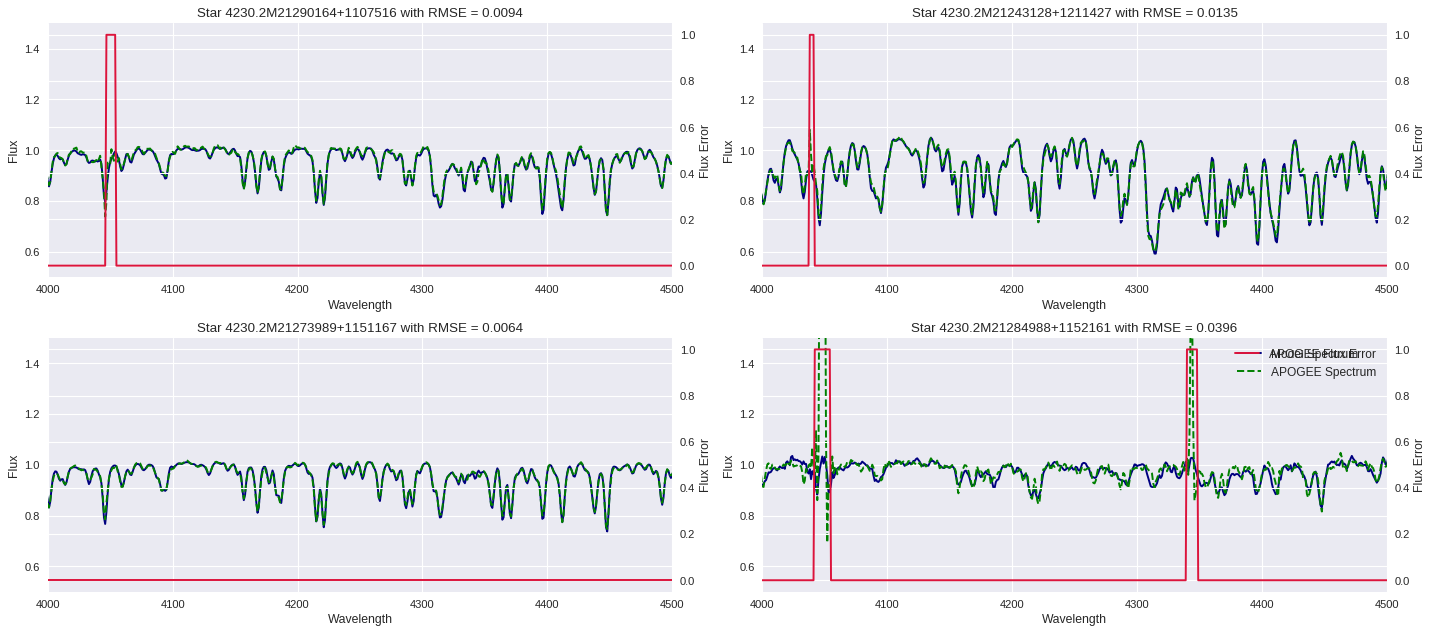

In [28]:
x_intervals = [[300, 800], [1300, 1800], [3600, 4100], [4100, 4600]]
fig, ax = plt.subplots(2, 2, figsize=(18,8))
for i in range(4):
    j = np.random.randint(0, 450)
    specfit = spectrum_fit(labels_train_scaled[j], coefficient_matrix=coefficient_matrix)
    ax[i//2, i%2].plot(specfit, c="navy", label="Model Spectrum")
    ax[i//2, i%2].set_ylabel("Flux"); ax[i//2, i%2].set_xlabel("Wavelength")
    ax[i//2, i%2].plot(spectrum_train[j], ls="--", c="g", label = "APOGEE Spectrum")
    ax2 = ax[i//2, i%2].twinx(); ax2.set_ylabel("Flux Error")
    ax2.plot(error_train[j]/1e10, c="crimson", label="APOGEE Flux Error")
    ax[i//2, i%2].set_title(f"Star {target_ids[j]} with RMSE = {np.sqrt(mean_squared_error(spectrum_train[j], specfit, sample_weight=good_pixels_train[j])):.4f}")
    ax[i//2, i%2].set_xlim(4000, 4500)
    ax[i//2, i%2].set_ylim(0.5, 1.5)
fig.tight_layout(); ax2.legend(); ax[-1,-1].legend();

# 5. Reversing the spectrum predicting model
## 5.1 Setting up a Maximum Likelihood Estimation of the Model 
Armed with our spectrum-from-labels predicting model, we will reverse this into a labels-from-spectrum predicting model, which is the model we actually want. The idea is that, for each star, there should be a set of labels that bring the generated spectrum as "close" as possible to its actual spectrum.

A question arises on the definition of "closeness". The most obvious candidate for measuring closeness between two sets, and the one we will use, is in a chi-squared sense (A more linear distance is also a good candidate, and could be explored). From this, we can define a likelihood, as a function of labels, which needs to be maximized. This likelihood is rewritten to a log-likelihood, and inversed, such that we wish to minimize it. The (non-negative) chi-squared log-likelihood will then be

\\[
\ln p\left(f_{n \lambda} | \boldsymbol{\theta}_{\lambda}, \boldsymbol \ell_{n}\right)=-\frac{1}{2} \frac{\left[f_{n \lambda}-\boldsymbol{\theta}_{\lambda}^{T} \cdot \boldsymbol\ell_{n}\right]^{2}}{\sigma_{n \lambda}^{2}}-\frac{1}{2} \ln \left(\sigma_{n \lambda}^{2}\right)
\\]

We have below defined the negative of such a log-likelihood, which includes the assumed errors in the pixels. As before, some pixels are tagged with extremely high errors, and will not contribute to the predictions.

In [0]:
def lnlike(labels, spec_actual, spec_error):
    y = spec_actual
    y_err = spec_error
    model = spectrum_fit(labels)
    inv_sigma2 = 1.0/(y_err**2)
    neg_ll = 0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))
    return neg_ll

## 5.2 Optimizing the Likelihood
All that remains is to pick an optimizer to minimize the negative log-likelihood. Scipy has a bunch of good options, and we went with the standard scipy.optimize.minimize, which defaults to the BFGS method. We initialize the likelihood with initial values of 0 across all labels, which is the mean values, after our scaling.

To our surprise, we found that many of the other methods were very unstable or refused to converge. Given that the likelihood surface is simply a sum of quadratic functions, we expected it to be rather well-behaved. Even though the BFGS method gives good results, it throws out a few warnings of "divide by zero", and "may not have converged due to precision loss". Further exploring method and convergence of the optimizer is definitively needed. It does, however, produce reliable results, so we leave it be for now.

In [30]:
labels_estimated_training_scaled = np.zeros((len(labels_train_scaled), 5))

for i in tqdm(range(len(labels_train_scaled))):
    spec_actual = spectrum_train[i]
    y_err = error_train[i]
    initial = (0,0,0,0,0)
    bounds = ((-5,5),(-5,5),(-5,5),(-5,5),(-5,5))
    res_1 = scipy.optimize.minimize(lnlike, initial, args=(spec_actual, y_err))
    labels_estimated_training_scaled[i] = res_1.x
np.save("labels_estimated_training_scaled.npy", labels_estimated_training_scaled)

100%|██████████| 1015/1015 [06:29<00:00,  3.84it/s]


In [0]:
labels_estimated_training_scaled = np.load("labels_estimated_training_scaled.npy")

In [32]:
labels_estimated_testing_scaled = np.zeros((len(labels_test_scaled), 5))
for i in tqdm(range(len(labels_test_scaled))):
    spec_actual = spectrum_test[i]
    y_err = error_test[i]
    initial = (0,0,0,0,0)
    bounds = ((-5,5),(-5,5),(-5,5),(-5,5),(-5,5))
    res_1 = scipy.optimize.minimize(lnlike, initial, args=(spec_actual, y_err))
    labels_estimated_testing_scaled[i] = res_1.x
np.save("labels_estimated_testing_scaled.npy", labels_estimated_testing_scaled)

100%|██████████| 501/501 [03:12<00:00,  3.10it/s]


In [0]:
labels_estimated_testing_scaled = np.load("labels_estimated_testing_scaled.npy")

### 5.2.1 Analysing the Results
Below, the results of the predicted labels are plotted against ASPCAP labels for the training set (left) and testing set (right). Bias and RMSE is also shown. The bias is simply mean label difference (predicted - ASCPCAP). Scaled RMSE is simply the RMSE of the scaled (0 mean, unit variance) labels, which should be somewhat comparable metric between different labels.

The results seem fairly good. A couple of things are immediately obvious. Teff, logg, and Fe/H, have much stronger correlation trends than Mg/Fe and Si/Fe. This indicates that the former 3 have a much stronger relationship with the shape of the spectrum than the latter 2. This can also be observed from the scaled RMSE. The bias is also relatively small, indicating no larger general off-shifts, but will be studied in more detail below.

A somewhat surprising observation is that the testing data is as good a fit as the training data. This is in some regard pleasing, at it means we haven't produced an overfitted model, which only mimics our data. It might, however, indicate that we could extract more information from our data, and build a more tightly fit model. Our approximations that the spectrum pixels are quadratic functions of the labels could be generalized to include higher order terms. This might further improve the predictive capabilities of our model.

In [0]:
labels_estimated_training = Scaler.inverse_transform(labels_estimated_training_scaled)
labels_estimated_testing = Scaler.inverse_transform(labels_estimated_testing_scaled)

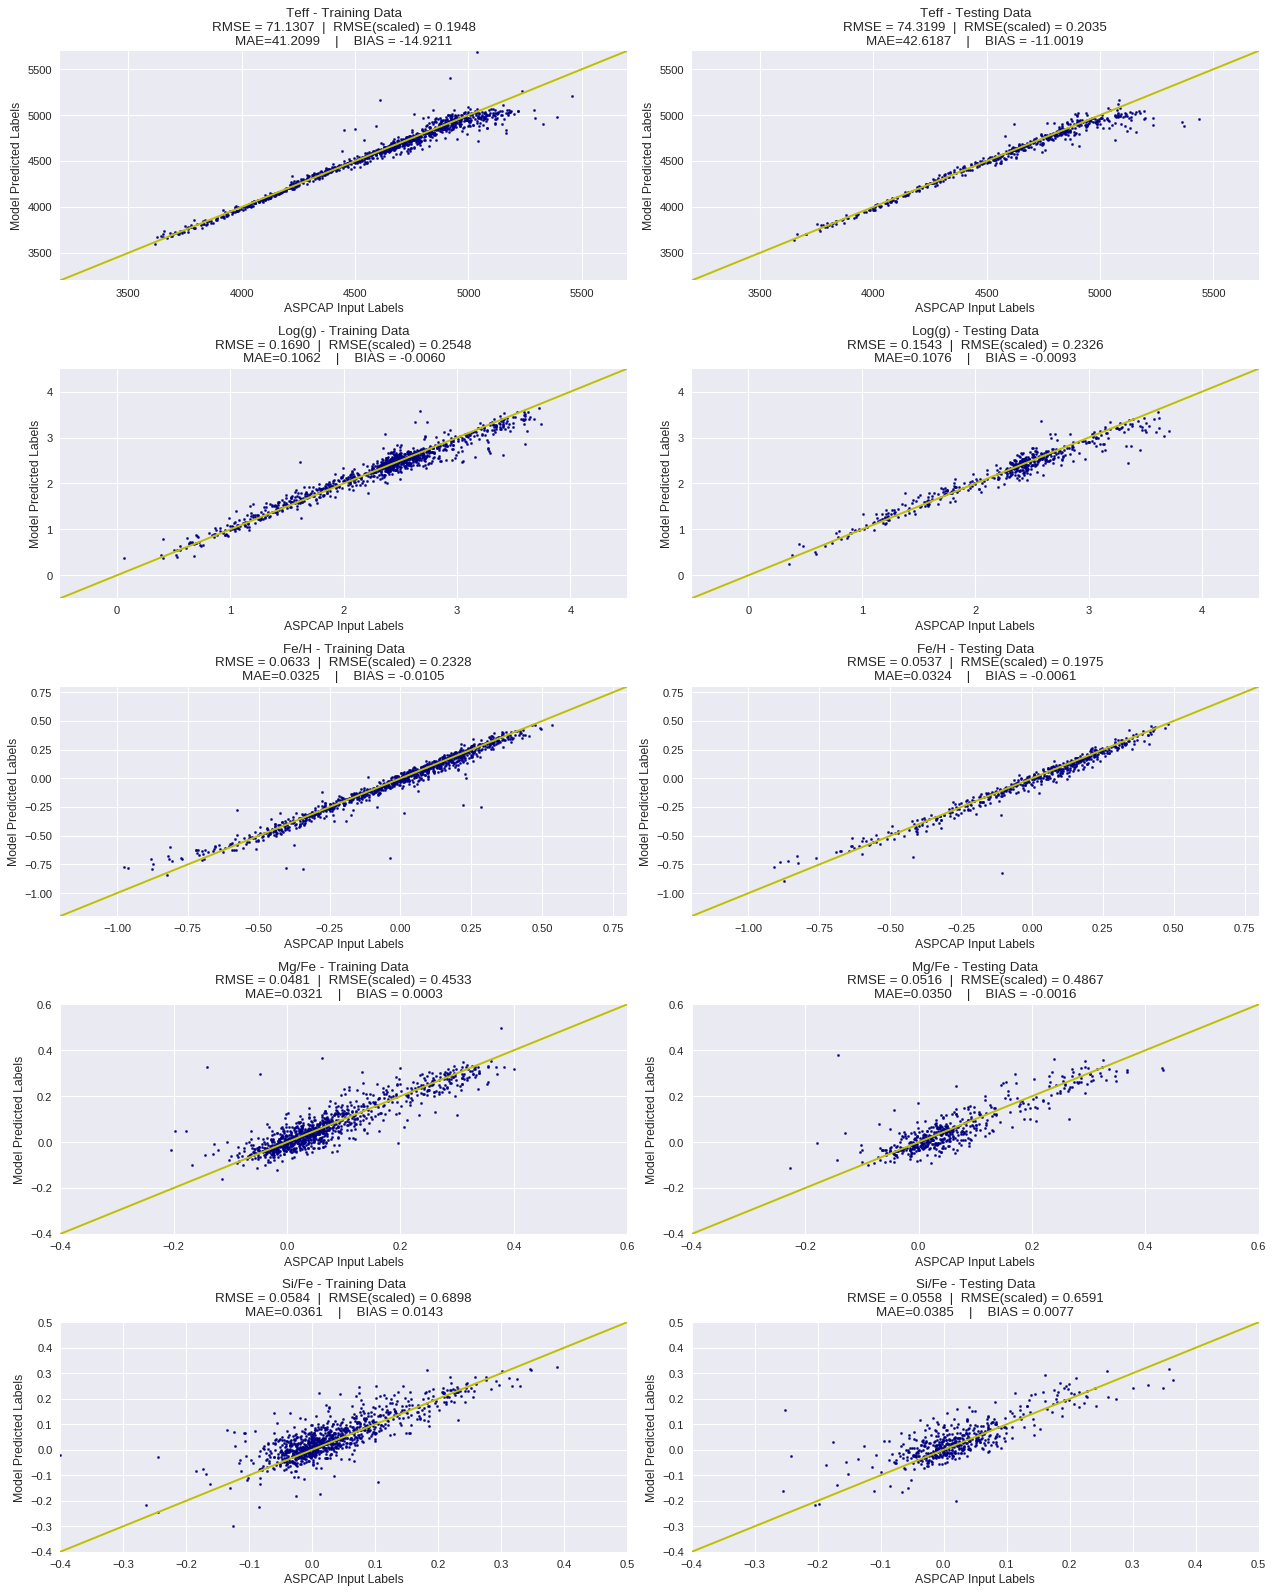

In [35]:
fig, ax = plt.subplots(5, 2, figsize = (16,20))
for i in range(5):
    RMS = np.sqrt(mean_squared_error(labels_estimated_training[:,i], labels_train[:,i]))
    RMS2 = np.sqrt(mean_squared_error(labels_estimated_training_scaled[:,i], labels_train_scaled[:,i]))
    MAE = mean_absolute_error(labels_estimated_training[:,i], labels_train[:,i])
    bias = np.sum(labels_estimated_training[:,i] - labels_train[:,i])/nr_training_stars
    ax[i, 0].scatter(labels_train[:,i], labels_estimated_training[:,i], s=4, c="navy")
    ax[i, 0].plot([-100,6000],[-100,6000], c="y")
    ax[i, 0].set_xlim(*label_xlims[i]); ax[i, 0].set_ylim(*label_xlims[i])
    ax[i, 0].set_title(f"{label_names[i]} - Training Data\nRMSE = {RMS:.4f}  |  RMSE(scaled) = {RMS2:.4f}\nMAE={MAE:.4f}    |    BIAS = {bias:.4f}")
    ax[i, 0].set_xlabel("ASPCAP Input Labels"); ax[i, 0].set_ylabel("Model Predicted Labels")
    RMS = np.sqrt(mean_squared_error(labels_estimated_testing[:,i], labels_test[:,i]))
    RMS2 = np.sqrt(mean_squared_error(labels_estimated_testing_scaled[:,i], labels_test_scaled[:,i]))
    MAE = mean_absolute_error(labels_estimated_testing[:,i], labels_test[:,i])
    bias = np.sum(labels_estimated_testing[:,i] - labels_test[:,i])/nr_training_stars
    ax[i, 1].scatter(labels_test[:,i], labels_estimated_testing[:,i], s=4, c="navy")
    ax[i, 1].plot([-100,6000],[-100,6000], c="y")
    ax[i, 1].set_xlim(*label_xlims[i]); ax[i, 1].set_ylim(*label_xlims[i])
    ax[i, 1].set_title(f"{label_names[i]} - Testing Data\nRMSE = {RMS:.4f}  |  RMSE(scaled) = {RMS2:.4f}\nMAE={MAE:.4f}    |    BIAS = {bias:.4f}")
    ax[i, 1].set_xlabel("ASPCAP Input Labels"); ax[i, 1].set_ylabel("Model Predicted Labels")
fig.tight_layout()


Below we have plotted the difference between predicted and ASPCAP labels, with ASPCAP values along the x-axis, to reveal trends in the data. The most obvious bias is that the model substantially under-predicts the effective temperature for high-temperature stars. This trend is also very visible in the take-one-out validation performed by the Cannon in Ness et al. 2018. The surface gravity seems to have a similar (but weaker) trend. This is unsurprising, as we concluded Log(g) and Teff to have a correlation in our initial label analysis. Fe/H also seems to be over-biased by the model in very low metalicities, although the data-points are few. The remaining labels show no obvious biases.

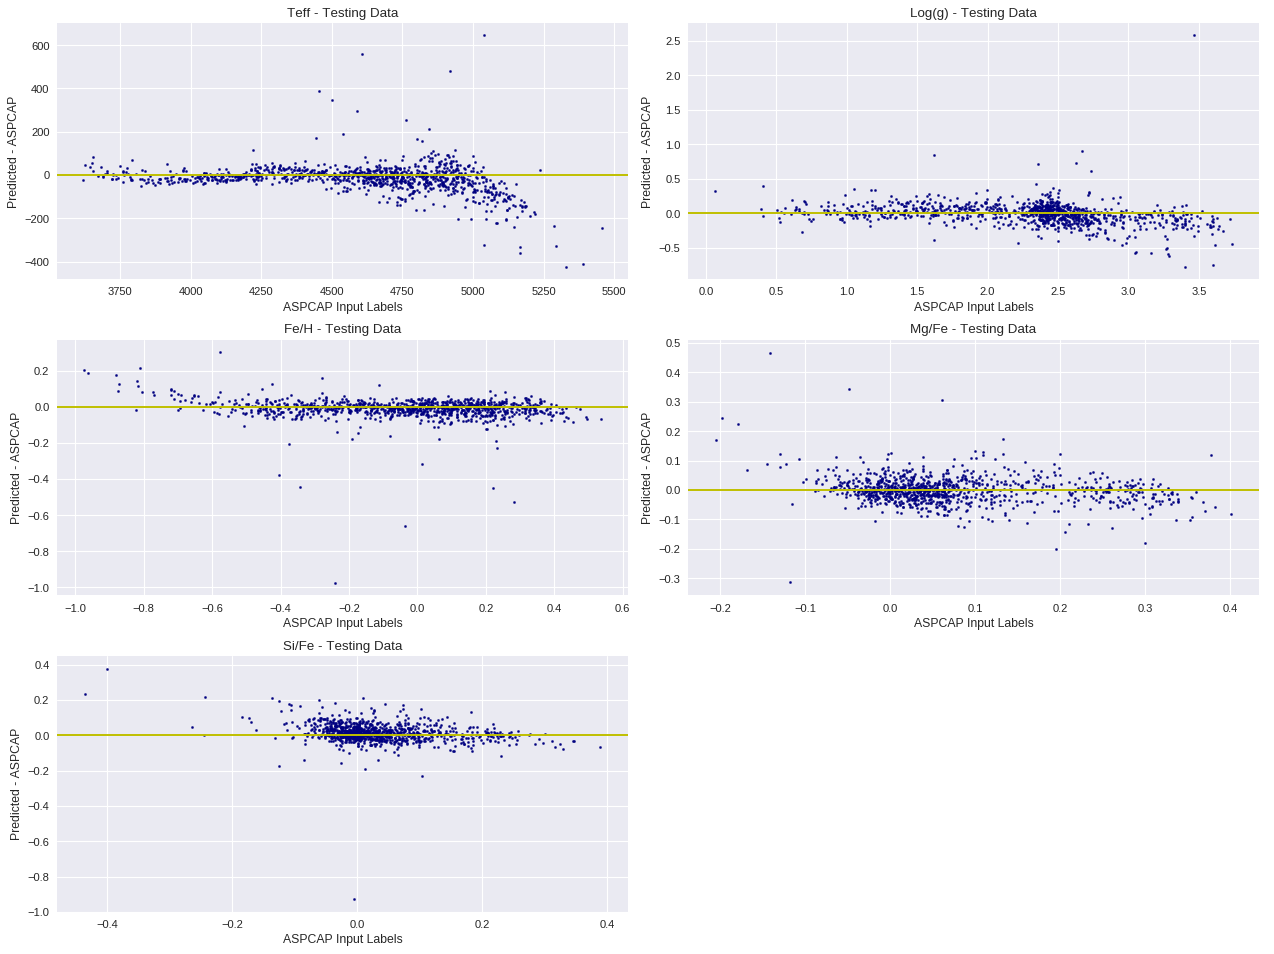

In [36]:
fig, ax = plt.subplots(3, 2, figsize=(16, 12))
for i in range(5):
    ax[i//2, i%2].scatter(labels_train[:,i], labels_estimated_training[:,i] - labels_train[:,i], s=4, c="navy")
    ax[i//2, i%2].axhline(y=0, c="y")
    ax[i//2, i%2].set_title(f"{label_names[i]} - Testing Data")
    ax[i//2, i%2].set_xlabel(f"ASPCAP Input Labels")
    ax[i//2, i%2].set_ylabel(f"Predicted - ASPCAP")
ax[-1, -1].axis('off')
plt.tight_layout();

## 5.3 A Kiel Diagram of the Results
Below we have plotted a Kiel diagram of the ~500 stars in the testing set. The data form a line, with decreasing Fe/H in up-left direction, in other words with increasing Teff and decreasing Log(g). There are some notable outliers to this trend, which indicates some suboptimal datapoints. On top, we have plotted two SDSS 6 Gyr isochrones generated by [MIST](http://waps.cfa.harvard.edu/MIST/), at Fe/H 0 and -1. Looking at the gradient of metallicity in our data, the two isochrones corresponds to the Fe/H trend we see. The Fe/H = -1 isochrone represent the outmost extreme of metallicity in our data, where we find few data points. The Fe/H = 0 seems to fall well onto the band of stars with the same metalicity. Our Kiel diagram does, in other words, look quite promising.

The absence of dwarf-stars can also be noted.

Below, we have also plotted the same plot, using the same stars, but this time with labels from the ASPCAP pipeline. We see no major different trends, and the occasional outlier is present here as well.

A comparable, more complete plot, derived from ASCPCAP labels, can be found in [Holtzman et al. (2015)](https://arxiv.org/abs/1501.04110), figure 12.

In [0]:
def get_isochrone(filename):
    """Returns an isochrone (bp_rp & mg) from a MIST generated .cmd isochrone file."""
    Teff = []
    logg = []
    with open(filename, "r") as infile:
        for i in range(13):  # Skipping info lines.
            infile.readline()
        for line in infile:
            words = line.split()
            Teff.append(float(words[4]))
            logg.append(float(words[5]))
    Teff = 10**np.array(Teff)
    logg = np.array(logg)
    return Teff, logg

In [0]:
Teff, logg = get_isochrone("MIST_iso_5c91f8dae5167.iso.cmd")
Teff2, logg2 = get_isochrone("MIST_iso_5c9460fc80da6.iso.cmd")

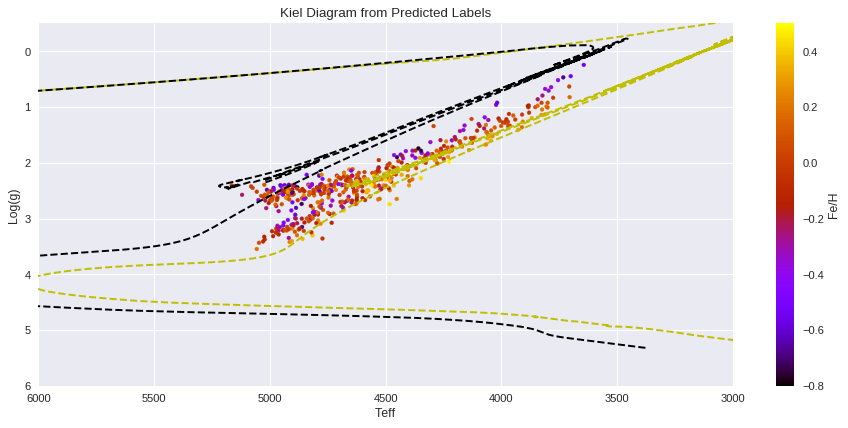

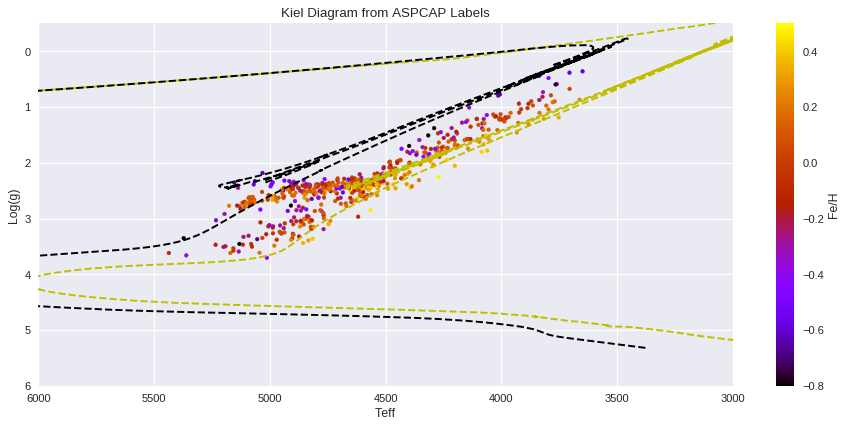

In [39]:
plt.figure(figsize=(14,6))
plt.scatter(labels_estimated_testing[:,0], labels_estimated_testing[:,1], c=labels_estimated_testing[:,2], s=12, cmap="gnuplot", vmin=-0.8, vmax=0.5)
plt.plot(Teff, logg, c="y", ls="--", label="6Gyr Isochrone, Fe/H = 0")
plt.plot(Teff2, logg2, c="k", ls="--", label="6Gyr Isochrone, Fe/H = -1")
cbar = plt.colorbar(); cbar.set_label("Fe/H")
plt.ylabel("Log(g)"); plt.xlabel("Teff"); plt.title("Kiel Diagram from Predicted Labels");
plt.ylim(6, -0.5); plt.xlim(6000, 3000);

plt.figure(figsize=(14,6))
plt.scatter(labels_test[:,0], labels_test[:,1], c=labels_test[:,2], s=12, cmap="gnuplot", vmin=-0.8, vmax=0.5)
plt.plot(Teff, logg, c="y", ls="--", label="6Gyr Isochrone, Fe/H = 0")
plt.plot(Teff2, logg2, c="k", ls="--", label="6Gyr Isochrone, Fe/H = -1")
cbar = plt.colorbar(); cbar.set_label("Fe/H")
plt.ylabel("Log(g)"); plt.xlabel("Teff"); plt.title("Kiel Diagram from ASPCAP Labels");
plt.ylim(6, -0.5); plt.xlim(6000, 3000);

## 5.4 Fitting an Unknown Spectrum with MCMC
### 5.4.1 Setup
We will now attempt to employ our model on an unknown spectrum. Instead of an optimizer, we will use MCMC. This will admittedly be must slower, but offer the advantage of much more information about the probability distributions of each parameter. The spectrum, with its provided error, is plotted below.

We define a chi-squared log-likelihood, with considerations of the errors we have been provided.

\\[
\ln p\left(f_{n \lambda} | \boldsymbol{\theta}_{\lambda}, \boldsymbol \ell_{n}\right)=-\frac{1}{2} \frac{\left[f_{n \lambda}-\boldsymbol{\theta}_{\lambda}^{T} \cdot \boldsymbol\ell_{n}\right]^{2}}{\sigma_{n \lambda}^{2}}-\frac{1}{2} \ln \left(\sigma_{n \lambda}^{2}\right)
\\]


Since the labels are scaled, we will simply set an uninformed prior of $\pm 5$ on all labels, corresponding to 5 standard deviations in each direction.

\\[
\ln{P(\boldsymbol l_n)} = \left\{\begin{array}{lr}
        0, & \text{for } -5\leq \boldsymbol l_n \leq 5 \\
        -\infty, & \text{otherwise }
        \end{array}\right\}
\\]

We employ 6 walkers, initiated at small deviations from zero, which is the mean of all labels. They are run for 15000 iterations.

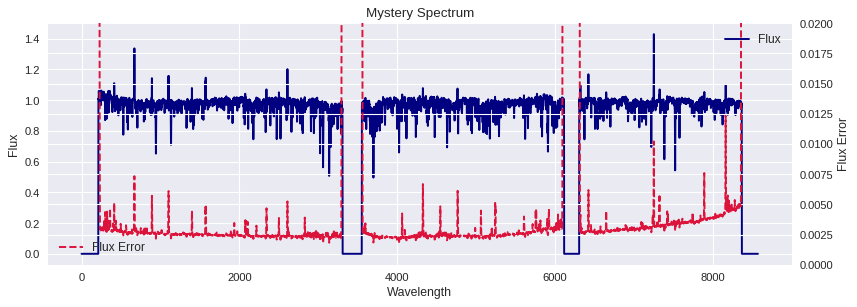

In [40]:
with fits.open("mystery_spec_wiped.fits") as infile:
    mystery_spec = (infile[1].data)
    mystery_spec_error = (infile[2].data)
    mystery_bitmask = (infile[3].data)

polyfit = get_band_polyfit(wl, mystery_spec, mystery_spec_error, degrees=(2,2,2))

mystery_spec /= polyfit
mystery_spec_error /= polyfit

fig, ax1 = plt.subplots(1, figsize=(12,4))
ax1.plot(mystery_spec, label="Flux", c="navy")
ax2 = ax1.twinx()
ax2.plot(mystery_spec_error, ls="--", c="crimson", label="Flux Error")
ax2.set_ylim(0, 0.02); ax1.set_xlabel("Wavelength"); ax1.set_ylabel("Flux"); ax2.set_ylabel("Flux Error")
ax1.legend(); ax2.legend(); ax1.set_title("Mystery Spectrum")

mystery_spec = mystery_spec[band_cut]
mystery_spec_error = mystery_spec_error[band_cut]

In [0]:
def lnlike(labels, spec_actual, spec_error):
    y = spec_actual
    y_err = spec_error
    model = spectrum_fit(labels)
    inv_sigma2 = 1.0/(y_err**2)
    ll = -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))
    return ll


def lnprior(labels):
    Teff, logg, FeH, MgFe, SiFe = labels
    if -5.0 <= Teff <= 5.0 and -5.0 <= logg <= 5.0 and -5.0 < FeH < 5.0 and -5.0 < MgFe < 5.0 and -5.0 < SiFe < 5.0:
        return 0.0
    return -np.inf

def lnprob(labels, y, yerr):
    lp = lnprior(labels)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(labels, y, yerr)

In [44]:
seed = 1995
np.random.seed(seed)
ndim, nwalkers = 5, 16
pos = [(0,0,0,0,0) + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

import emcee
print(f"emcee version = {emcee.__version__}")
x = labels_train
y_data = mystery_spec
y_err = mystery_spec_error
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(y_data, y_err))

emcee version = 2.2.1


In [0]:
niterations = 15000
sampler.reset()
sampler.run_mcmc(pos, niterations);

### 5.4.2 Convergence
Below, the label-values of each walker is plotted for each iteration. It is clear that the walkers reached some steady values relatively early on. Below, we also have the log-probability plotted over each step. We are confident that our results have converged. To leave the results unaffected by initial conditions, we implement a burn-in, cutting off all sampler values before 8000 iterations were reached.

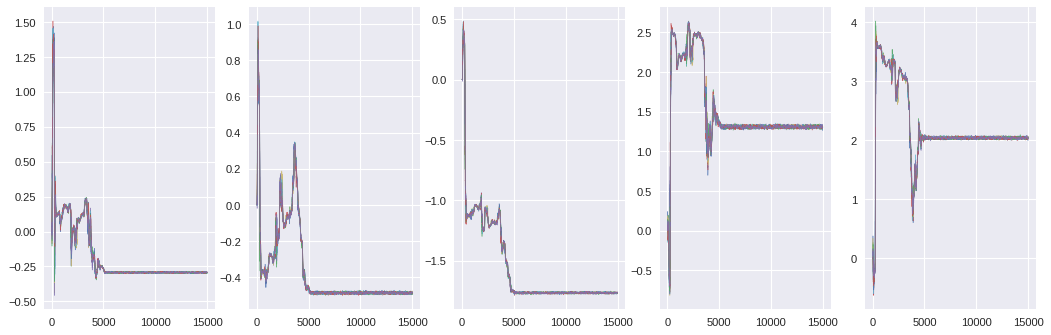

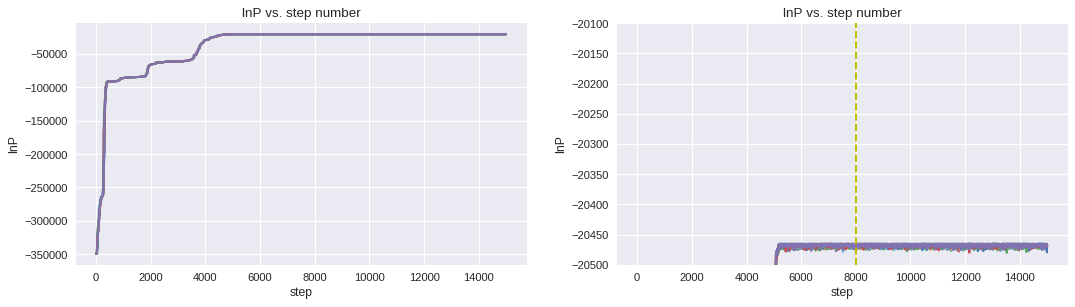

In [46]:
fig, ax = plt.subplots(1, 5, figsize=(16,5))

for i,j in enumerate(sampler.chain[0,0,:]):
    ax[i].plot(sampler.chain[:,:,i].T, alpha=0.8, lw=0.5)
fig, ax = plt.subplots(1, 2, figsize=(16,4))
ax[0].set_ylabel('lnP'); ax[0].set_xlabel('step'); ax[0].set_title('lnP vs. step number');
ax[1].set_ylabel('lnP'); ax[1].set_xlabel('step'); ax[1].set_title('lnP vs. step number');
ax[0].plot(sampler.lnprobability.T);
ax[1].plot(sampler.lnprobability.T);
ax[1].set_ylim(-20500, -20100)
ax[1].axvline(x=8000, ls="--", c="y");

In [0]:
burn_in = 8000
samples = sampler.chain[:, burn_in:, :].reshape((-1, ndim))

### 5.4.3 Results
In the corner plot, we observe some of the same correlations as in our original analysis of all labels. There are also some notable differences, especially the strong relationship between Fe/H and Logg(g).

Looking at our printouts of derived values, with errors, below the graphs, we see that all labels fall in reasonable (but completely unconfirmable) ranges. We have also included the average error in each label reported by the ASPCAP pipeline. A difference is very apparent, where the ASPCAP values are orders of magnitude larger. Our errors are the standard deviation found by the MCMC walkers when traveling around our log-likelihood space. This is not at all representative for the actual inaccuracy of our prediction, because it assumes our log-likelihood is absolutely correct, which depends on our model and coefficient being without error altogether. Error-sources outside the immediate uncertainties in the log-likelihood is not included in our estimate, and the ASPCAP values probably represent a much more realistic estimate.

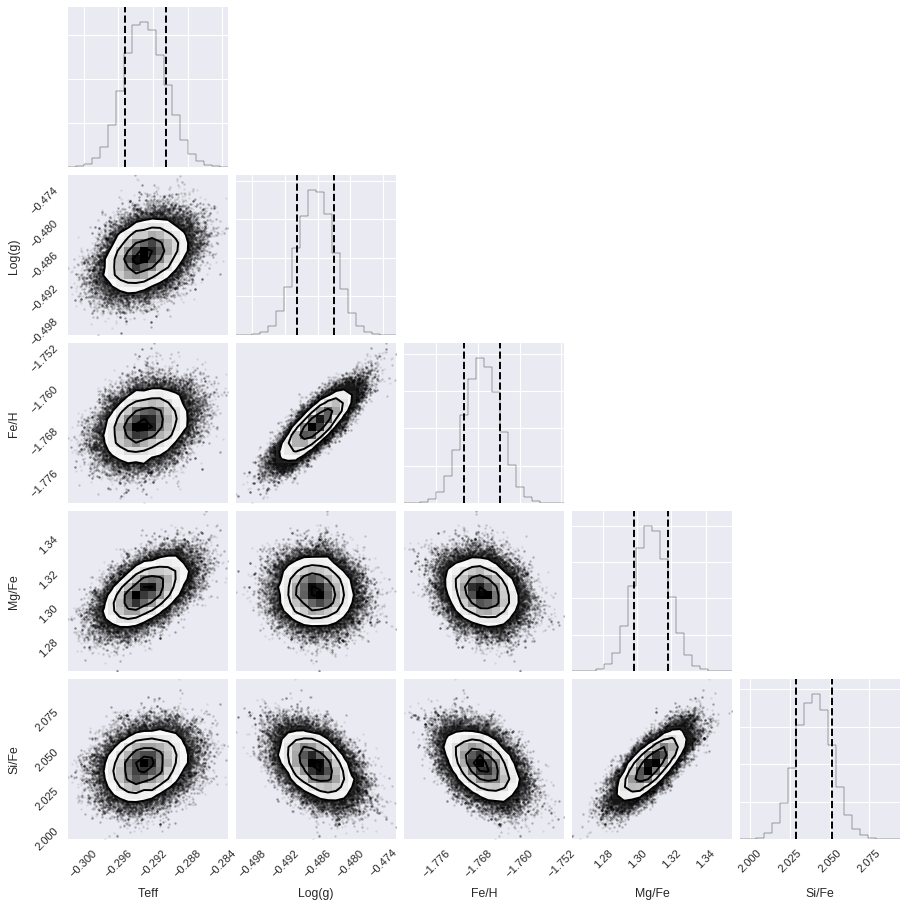

In [48]:
fig = corner.corner(samples, quantiles=[0.16, 0.84], labels=label_names);

In [49]:
avg_label_errors = np.mean(label_errors, axis=0)

mystery_labels_scaled = np.percentile(samples, 50, axis=0)
mystery_labels = Scaler.inverse_transform(mystery_labels_scaled)
labels_perc = Scaler.inverse_transform(np.percentile(samples, [16, 50, 84], axis=0))
v = labels_perc[0], labels_perc[1]-labels_perc[0], labels_perc[2] - labels_perc[1]
print(f"          Predicted Values     +std       -std     ASCPCAP std")
for i in range(5):
    print(f"{label_names[i]:6s} = {v[0][i]:14.4f}    |  {v[1][i]:6.4f}  |  {v[2][i]:6.4f}  |  {avg_label_errors[i]:8.4f}")

          Predicted Values     +std       -std     ASCPCAP std
Teff   =      4489.7657    |  0.8511  |  0.8941  |   74.4333
Log(g) =         1.9600    |  0.0022  |  0.0023  |    0.0531
Fe/H   =        -0.5213    |  0.0009  |  0.0009  |    0.0084
Mg/Fe  =         0.2120    |  0.0011  |  0.0011  |    0.0200
Si/Fe  =         0.2051    |  0.0010  |  0.0009  |    0.0253


## 5.5 Metalicity Analysis
A large contributing factor to the spectral absorption lines is the metallicity, Fe/H. Below, we have used the spectral model we have built to animate how the spectrum changes with metallicity. We create a spectrum with mean label values for everything but Fe/H. We then vary Fe/H from -1 to 0.5, and animate how the spectrum responds, for wavelength between 16000 and 16200 Angstrom.

As we can see, the absorption lines visible at -1 Fe/H becomes more and prominent towards higher values. I assume this indicates a more diverse atmosphere, with more non-H/He elements, and therefore more possibilities for wavelengths of absorption.

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

FeH_list = np.linspace(-1, 0.5, 200)
labels = label_means
print("Spectrum Values:")
for i in [0,1,3,4]:
    print(f"{label_names[i]:8s} = {label_means[i]:10.4f}")

fig = plt.figure();
ax = plt.axes(xlim=(16000, 16200), ylim=(0, 1.5))
ax.set_ylabel("Normalized Flux")
ax.set_xlabel("Wavelength [Angstrom]")
line, = ax.plot([], [], lw=1, c="navy");

def init():
    line.set_data([], [])
    return line,

def animate(i):
    x = wl_reduced
    labels[2] = FeH_list[int(i)]
    labels_scaled = Scaler.transform(labels.reshape(1, -1))[0]
    y = spectrum_fit(labels_scaled)
    line.set_data(x, y)
    ax.set_title(f"Fe/H = {FeH_list[i]:.2f}")
    return line,

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=50, blit=True);

anim.save('asdf.gif', writer='imagemagick', dpi=120);
plt.close(fig);
# anim.save('asdf.mp4', dpi=200);

MovieWriter imagemagick unavailable. Trying to use pillow instead.


Spectrum Values:
Teff     =  4597.6016
Log(g)   =     2.2849
Mg/Fe    =     0.0743
Si/Fe    =     0.0334


In [51]:
from IPython.display import HTML
HTML('<img src="asdf.gif">')

## 5.6 Binary Star Considerations
Many observed stars might, in reality, be binary stars, which APOGEE has been incapable of separating because they are either far from earth or close to each other. Undetected binary stars will cause the observed spectrum to be a superposition of the two individual spectra, as flux-contributions from both stars will be measured. If such a binary system is fitted using a single-star spectral model, the derived labels will bias towards inaccurate values. [El-Badry et al. 2018](https://academic.oup.com/mnras/article/473/4/5043/4566523) explores this in detail and finds that such a wrongful fit will negatively bias the effective temperature and metallicity. This bias is diminished if the mass of the two stars are very different, as the smaller star will then contribute negligibly to the total spectrum.

The detection of such binary systems has also been studied in the literature. Often, when visual separation fails, one tries to detect binary systems by looking for doppler shifts in the spectrum, as the binary stars shift in velocities as they orbit each other. This is dependent on the period being reasonably small, which is often not the case. [El-Badry et al. 2017](https://arxiv.org/abs/1711.08793) explores a data-driven approach on binary star detecting, using the Cannon. They find that, if the stars differ moderately ($ 0.4 < m_1/m_2 < 0.8$) in mass, one should find that the spectrum will fit a superposition of two single-star spectra better than a single-star spectrum model. Such an approach could be implemented in our model.

# 6. An Alternate Approach - Neural Network in Keras
## 6.1 Motivation and Introduction
Finally, we will present an entirely different data-driven model - a neural network. A neural network holds a series of both advantages and disadvantages so our model so far. 

One advantage is that, while expensive to train, a neural network is very cheap to apply to new data. In contrast, in our earlier optimize-driven model, the most expensive part wasn't actually the training, but the optimizer fitting to new data. This can actually be a huge problem - training of a model is usually done with a rather limited set of data, while one often wishes to apply this model to data orders of magnitude larger in size. Another, at least superficial advantage, is the initial simplicity of a neural network. Simply putting the spectra into one end and the labels in the other yields acceptable results without much thinking. 

As a counter, neural networks can be huge black boxes and hard to master. The architectural and hyperparameter configurations are endless, and often with little intuitive guidance. A neural network can also be incapable of effectively taking advantage of all information available, as with the flux errors in our case, as we soon will see.

## 6.2 Setup
We will be constructing our network with Google's Tensorflow, with Keras as a frontend. We will focus on standard sequential dense layers, with no huge surprises. We will later expand our dataset with some data augmentation.

The data is divided into training and testing sets of 67% and 33%, respectively, as before, and linearly scaled to zero mean and unit variance, as before.

A simple network of 5 hidden layers, of sizes 1000, 2000, 2000, 500, 200, and 20 is set up below. All with linear activation, which helped with certain convergence-issues. It was found that this layer size provided the best results within reasonable training time, and changing the layer sizes and numbers (within reason) did not noticeably change the final results. This presented a total of 13'623'325 trainable parameters. A batch size of 32 was chosen, together with 250 epochs, beyond which the results changed little. The Adam optimizer was used, with the amsgrad option enabled. 

In [52]:
import tensorflow as tf
from tensorflow import keras
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Activation, LocallyConnected1D, Conv1D, Reshape
from keras.callbacks import ModelCheckpoint, History
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

print(tf.__version__)

1.13.1


Using TensorFlow backend.


In [53]:
input_train, input_test, err_train, err_test, output_train, output_test = train_test_split(spec_norm_reduced2, spec_error_norm_reduced2, labels2, test_size=0.33, random_state=42, shuffle=True)

nr_training_stars, nr_testing_stars = input_train.shape[0], input_test.shape[0]
print(f"Divided data into training set of {nr_training_stars} objects, and testing set of {nr_testing_stars} objects.")

ScalerNN = preprocessing.StandardScaler()
ScalerNN.fit(output_train)
output_train_scaled = ScalerNN.transform(output_train)
output_test_scaled = ScalerNN.transform(output_test)

Divided data into training set of 1015 objects, and testing set of 501 objects.


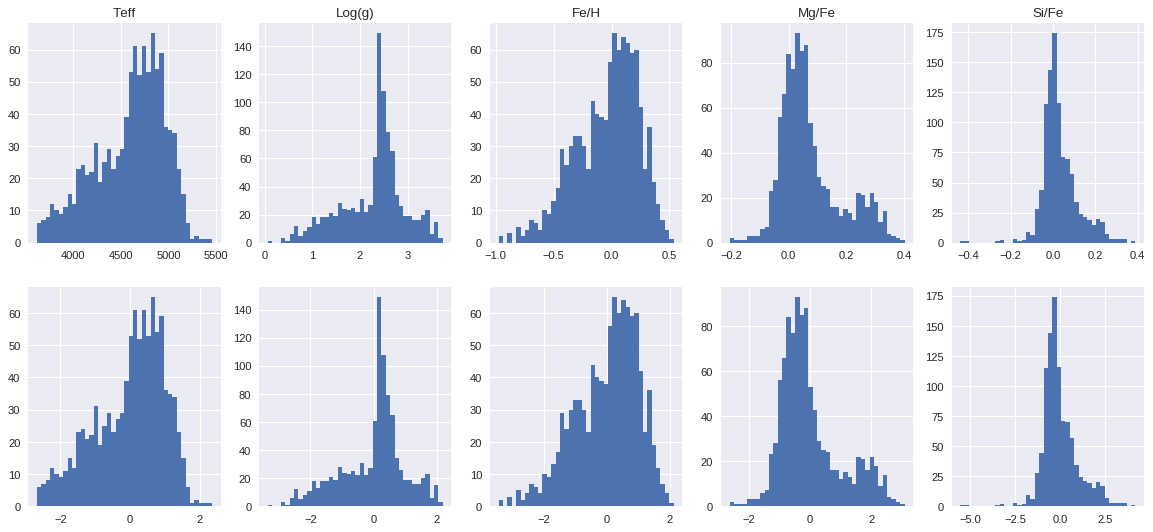

In [54]:
fig, ax = plt.subplots(2, 5, figsize=(18,8))
for i in range(5):
    ax[0,i].set_title(label_names[i])
    ax[0,i].hist(output_train[:,i], bins=40)
    ax[1,i].hist(output_train_scaled[:,i], bins=40)

In [55]:
opti = optimizers.adam(amsgrad=True)#, decay=0.01)
def nn_clf():
    model = Sequential()
    model.add(Dense(1000, input_shape=(7214,), activation="linear", kernel_initializer='random_uniform'))
    model.add(Dense(2000,  activation="linear", kernel_initializer='random_uniform'))
    model.add(Dense(2000,  activation="linear", kernel_initializer='random_uniform'))
    model.add(Dense(200,  activation="linear", kernel_initializer='random_uniform'))
    model.add(Dense(20, activation="linear", kernel_initializer='random_uniform'))
    model.add(Dense(5, activation="linear", kernel_initializer='random_uniform'))
    model.compile(optimizer=opti, loss='mean_squared_error',  metrics=['mae',"mse"])
    return model

Instructions for updating:
Colocations handled automatically by placer.


In [56]:
nn_clf().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1000)              7215000   
_________________________________________________________________
dense_2 (Dense)              (None, 2000)              2002000   
_________________________________________________________________
dense_3 (Dense)              (None, 2000)              4002000   
_________________________________________________________________
dense_4 (Dense)              (None, 200)               400200    
_________________________________________________________________
dense_5 (Dense)              (None, 20)                4020      
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 105       
Total params: 13,623,325
Trainable params: 13,623,325
Non-trainable params: 0
________________________________________________________________

## 6.3 Run and Results
As before, the predicted results are plotted against again ASPCAP labels below, with bias, RMSE, and MAE. As we can see, the networks , by all means, successful, making predictions of comparable quality to our former predictive model. It does, however, lag somewhat behind with a ~30% higher error.

In [57]:
clf = KerasRegressor(build_fn=nn_clf, batch_size=32, epochs=250)
clf.fit(input_train, output_train_scaled)

Instructions for updating:
Use tf.cast instead.
Epoch 1/250
1015/1015 [==============================] - 3s 3ms/step - loss: 24.5587 - mean_absolute_error: 3.0938 - mean_squared_error: 24.5587
Epoch 2/250
1015/1015 [==============================] - 1s 781us/step - loss: 1.1781 - mean_absolute_error: 0.8499 - mean_squared_error: 1.1781
Epoch 3/250
1015/1015 [==============================] - 1s 767us/step - loss: 1.0668 - mean_absolute_error: 0.8078 - mean_squared_error: 1.0668
Epoch 4/250
1015/1015 [==============================] - 1s 768us/step - loss: 0.9982 - mean_absolute_error: 0.7811 - mean_squared_error: 0.9982
Epoch 5/250
1015/1015 [==============================] - 1s 770us/step - loss: 0.9648 - mean_absolute_error: 0.7659 - mean_squared_error: 0.9648
Epoch 6/250
1015/1015 [==============================] - 1s 772us/step - loss: 0.9228 - mean_absolute_error: 0.7467 - mean_squared_error: 0.9228
Epoch 7/250
1015/1015 [==============================] - 1s 769us/step - loss: 0.8

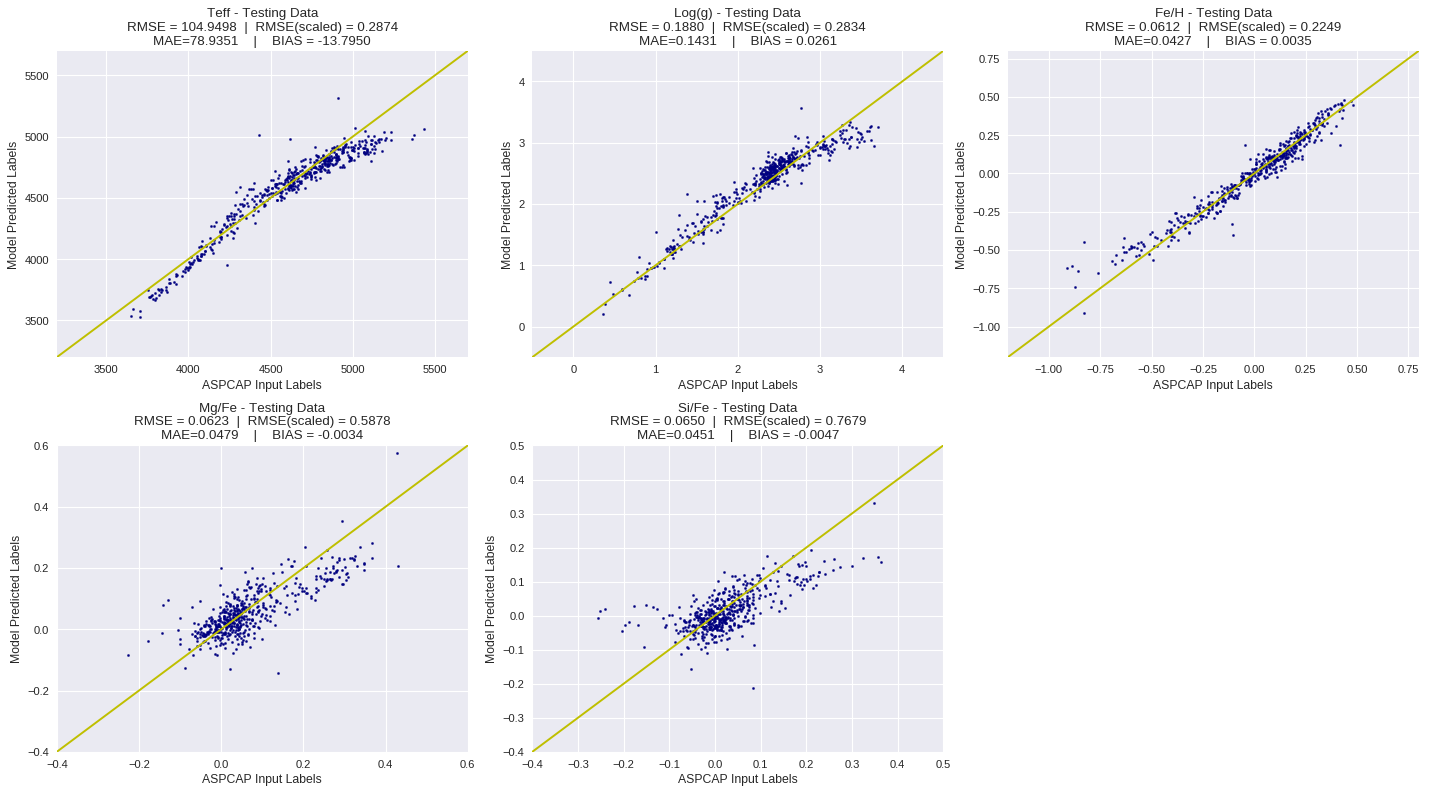

In [58]:
labels_estimated_testing_scaled = clf.predict(input_test)

labels_estimated_testing = ScalerNN.inverse_transform(labels_estimated_testing_scaled)

fig, ax = plt.subplots(2, 3, figsize = (18,10))
for i in range(5):
    RMS = np.sqrt(mean_squared_error(labels_estimated_testing[:,i], labels_test[:,i]))
    RMS2 = np.sqrt(mean_squared_error(labels_estimated_testing_scaled[:,i], labels_test_scaled[:,i]))
    MAE = mean_absolute_error(labels_estimated_testing[:,i], labels_test[:,i])
    bias = np.sum(labels_estimated_testing[:,i] - labels_test[:,i])/nr_training_stars
    ax[i//3, i%3].scatter(labels_test[:,i], labels_estimated_testing[:,i], s=4, c="navy")
    ax[i//3, i%3].plot([-100,6000],[-100,6000], c="y")
    ax[i//3, i%3].set_xlim(*label_xlims[i]); ax[i//3, i%3].set_ylim(*label_xlims[i])
    ax[i//3, i%3].set_title(f"{label_names[i]} - Testing Data\nRMSE = {RMS:.4f}  |  RMSE(scaled) = {RMS2:.4f}\nMAE={MAE:.4f}    |    BIAS = {bias:.4f}")
    ax[i//3, i%3].set_xlabel("ASPCAP Input Labels"); ax[i//3, i%3].set_ylabel("Model Predicted Labels")
ax[-1,-1].axis('off')
plt.tight_layout();

## 6.3 Expanding the Model - Data Augmentation
One of the main disadvantages of the neural network is its inability to make direct use of the provided spectrum errors One way of indirectly doing this, together with creating a larger dataset, is data augmentation.

We will bootstrap an increased dataset of size 10'000, 10 times the size of our original set, sampled from our original dataset. The sampling will be performed by randomly picking stars in our dataset (with a slight bias towards stars with a lower total error), and slightly augmenting their spectrum. This is done independently on each pixel, picking a random value sampled from a gaussian curve with their respective standard errors. This is performed with the ```numpy.random.normal``` module.

\\[
  f'  = f + \epsilon, \quad\quad P(\epsilon) = \frac{1}{\sqrt{2\sigma_f^2}} e^{\epsilon^2/\sigma_f^2} 
\\]

One question that arises is how to deal with the "bad" pixels, marked with $10^{10}$ errors. It is obviously unacceptable to leave them as such in the sampling. We found that setting such errors down to 0.05 provided the best results. This is on the very high end of what found naturally in the dataset.

The network layout will be left the same, as we are still trying to fit the same overall model. We have however substantially increased our batch size, to 512, to reflect our increased data size. We have also increased the number of epochs to 1000. This might raise concerns of overfitting, but we have this time let Keras set aside 20% of our dataset as a validation set. Keras can then be asked to only load the epoch in which the MSE of this validation data was at its lowest. 

As we can see from the figures below, the results are very promising, closing almost the entire gap the original model had on our neural network. Below this, we have plotted a figure of MSE (green), together with validation data MSE (blue). The 10 lowest validation data MSE are shown as red dots. As we can see, we have not overfitted our data, as the validation MSE is still decreasing, and a longer run might actually further improve our results.

In [0]:
error_aug = err_train.copy()
error_aug[error_aug > 0.1] = 0.05
star_weights = 1/(100 + np.sum(error_aug, axis=1))
star_weights = star_weights/np.sum(star_weights)
aug_input = np.zeros((10000, nr_pixels_reduced))
aug_output = np.zeros((10000, 5))

samples_idx = np.random.choice(np.arange(0, nr_training_stars), size=(10000), p=star_weights)
for i in range(10000):
    chosen_star = samples_idx[i]
    aug_input[i] = input_train[chosen_star] + np.random.normal(loc=0, scale=error_aug[chosen_star], size=nr_pixels_reduced)
    aug_output[i] = output_train_scaled[chosen_star]

In [60]:
opti = optimizers.adam(amsgrad=True)
def nn_clf():
    model = Sequential()
    model.add(Dense(1000, input_shape=(7214,), activation="linear", kernel_initializer='random_uniform'))
    model.add(Dense(2000,  activation="linear", kernel_initializer='random_uniform'))
    model.add(Dense(2000,  activation="linear", kernel_initializer='random_uniform'))
    model.add(Dense(200,  activation="linear", kernel_initializer='random_uniform'))
    model.add(Dense(20, activation="linear", kernel_initializer='random_uniform'))
    model.add(Dense(5, activation="linear", kernel_initializer='random_uniform'))
    model.compile(optimizer=opti, loss='mean_squared_error',  metrics=['mae',"mse"])
    return model

mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')

history = History()
clf = KerasRegressor(build_fn=nn_clf, batch_size=512, epochs=1000, callbacks=[mcp_save, history], validation_split=0.20)
history = clf.fit(aug_input, aug_output)

Train on 8000 samples, validate on 2000 samples
Epoch 1/1000
8000/8000 [==============================] - 3s 348us/step - loss: 41.2039 - mean_absolute_error: 4.3904 - mean_squared_error: 41.2039 - val_loss: 6.3167 - val_mean_absolute_error: 1.9117 - val_mean_squared_error: 6.3167
Epoch 2/1000
8000/8000 [==============================] - 1s 154us/step - loss: 3.0954 - mean_absolute_error: 1.4157 - mean_squared_error: 3.0954 - val_loss: 1.4174 - val_mean_absolute_error: 0.9457 - val_mean_squared_error: 1.4174
Epoch 3/1000
8000/8000 [==============================] - 1s 150us/step - loss: 1.1858 - mean_absolute_error: 0.8603 - mean_squared_error: 1.1858 - val_loss: 1.0695 - val_mean_absolute_error: 0.8252 - val_mean_squared_error: 1.0695
Epoch 4/1000
8000/8000 [==============================] - 1s 149us/step - loss: 1.0040 - mean_absolute_error: 0.7856 - mean_squared_error: 1.0040 - val_loss: 0.9433 - val_mean_absolute_error: 0.7523 - val_mean_squared_error: 0.9433
Epoch 5/1000
8000/8000

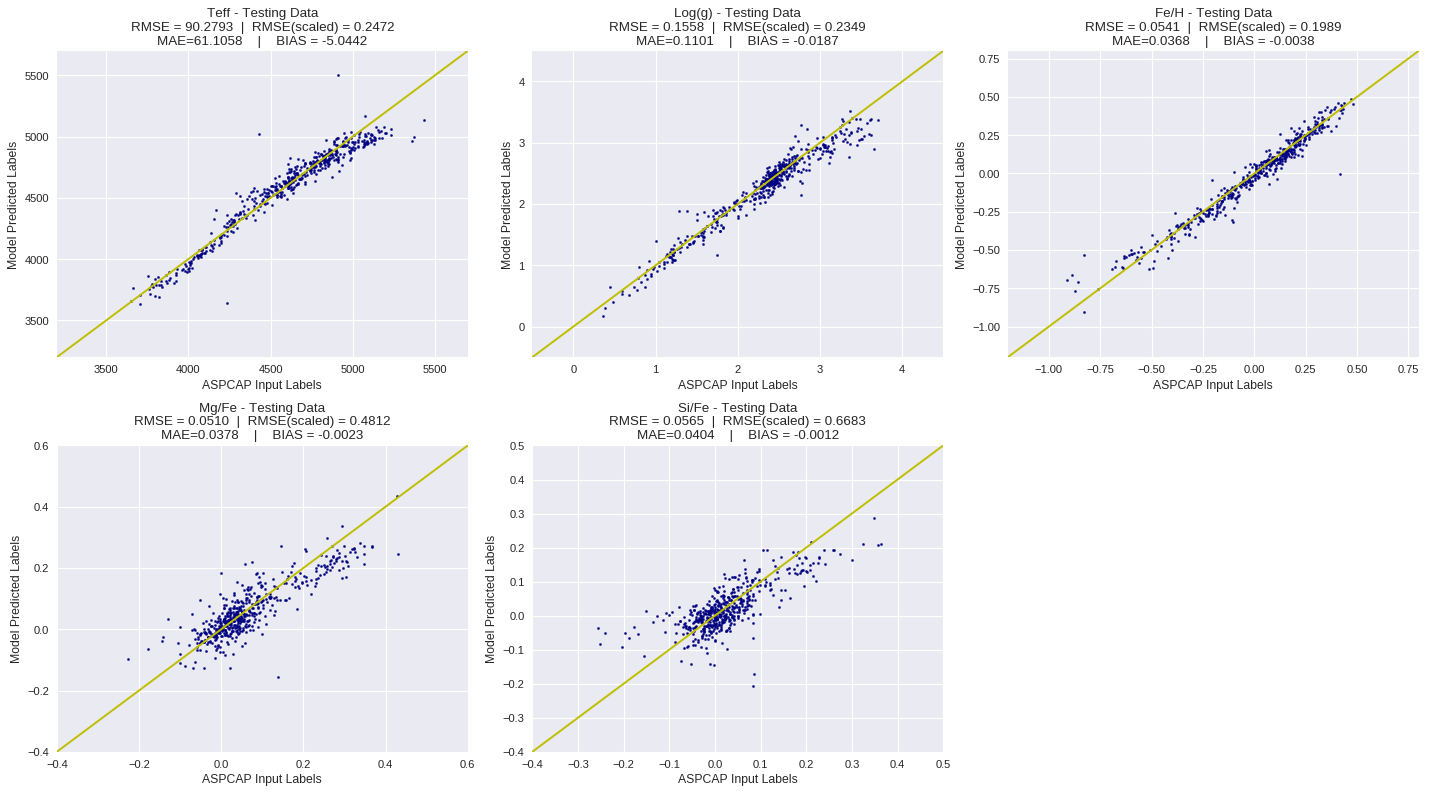

In [67]:
model = nn_clf()
model.load_weights(".mdl_wts.hdf5")

labels_estimated_testing_scaled = model.predict(input_test)

labels_estimated_testing = ScalerNN.inverse_transform(labels_estimated_testing_scaled)

fig, ax = plt.subplots(2, 3, figsize = (18,10))
for i in range(5):
    RMS = np.sqrt(mean_squared_error(labels_estimated_testing[:,i], labels_test[:,i]))
    RMS2 = np.sqrt(mean_squared_error(labels_estimated_testing_scaled[:,i], labels_test_scaled[:,i]))
    MAE = mean_absolute_error(labels_estimated_testing[:,i], labels_test[:,i])
    bias = np.sum(labels_estimated_testing[:,i] - labels_test[:,i])/nr_training_stars
    ax[i//3, i%3].scatter(labels_test[:,i], labels_estimated_testing[:,i], s=4, c="navy")
    ax[i//3, i%3].plot([-100,6000],[-100,6000], c="y")
    ax[i//3, i%3].set_xlim(*label_xlims[i]); ax[i//3, i%3].set_ylim(*label_xlims[i])
    ax[i//3, i%3].set_title(f"{label_names[i]} - Testing Data\nRMSE = {RMS:.4f}  |  RMSE(scaled) = {RMS2:.4f}\nMAE={MAE:.4f}    |    BIAS = {bias:.4f}")
    ax[i//3, i%3].set_xlabel("ASPCAP Input Labels"); ax[i//3, i%3].set_ylabel("Model Predicted Labels")
ax[-1,-1].axis('off')
plt.tight_layout();

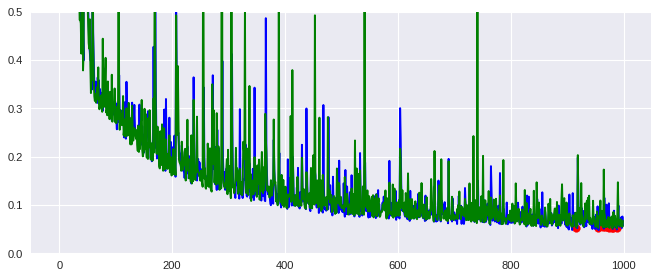

In [64]:
MSE = np.array(history.history['mean_squared_error'])
val_MSE = np.array(history.history['val_mean_squared_error'])
plt.ylim(0, 0.5)
asdf = np.argsort(val_MSE)[:10]
plt.plot(MSE, c="b")
plt.plot(val_MSE, c="g")
plt.scatter(asdf, val_MSE[asdf], c="r")

## 6.2 Considerations and Hindsight
A lot of approaches was attempted to increase the network's accuracy, with some small improvements gained after much trying and failing.

We believe the main reason the earlier predictive model outperforms the neural network is its direct access to the error data. We, therefore, attempted including the errors in the network learning set. This did not improve the results. I believe the main problem with this, using a standard dense layer, is that is allows for cross-communications between every flux-pixel and every error-pixel. In theory, the network should be able to map the correct error to the correct flux, given enough data, but with several thousand of each, I believe this seems futile in this scenario. A probably much stronger approach is, somehow, only allowing each flux-pixel to communicate with its own error-pixel, through some local layers.

We also had a lot of problems with convergence. Starting out, the loss function refused to converge, staying steadily at 1 forever. This went away when all layers were switching to linear (the last layer was of course already linear, due to presence of negative labels). Later, the network had a tendency to spike in loss and MSE by orders of magnitude at certain intervals (usually 50-200 epochs). This went away when the amsgrad option in the Adam optimizer was turned on. It is unknown why.


We also considered many methods for cleaning up bad data. Mostly by trying to reset "off" values to some default. For example, setting value < 0.2 or values > 1.2 to 1, which acts as sort of a default. This did not yield better results, probably because these offsets are also present in the confirmation set. None of the attempt produced any noticeable difference.

#  7. Result Comparison
 Below we see a table of the RMSE and bias comparing to ASPCAP labels. We see that the second neural network implementation closes almost the entire gap between the first approach and the original model.

### Table of RMSE and bias for each model
|              |  Model 1   | NN 1  |                       NN 2 |
| -----        | -----------     |  -------                       | -------    |
|  Teff    |   74.32 (-11.0)                 | 104.95 (-13.8 |  90.28 (-5.044) |          
|    Log(g)   | 0.1543 (-0.0093)            | 0.188 (-0.0261) |  0.156 (-0.0187) |
|   Fe/H      |  0.0537 (-0.0061) | 0.0.0612 (0.0035)    |  0.0541 (-0.0038) |
|   Mg/Fe    |   0.0516 (-0.0016) | 0.0.0623 (--0.0034)    |  0.0510 (-0.0023) |
|   Si/Fe      | 0.0558 (0.0077)    |  0.0650 (-0.0047)   |  0.0404 (-0.0012) |